In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statistics
import warnings
warnings.filterwarnings('ignore')
import itertools
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

# Overview
This notebook is my first look into the data I am using. I sourced the data from Zillow and changed from their wide format to a long format.

In [6]:
wide_ts = pd.read_csv('../dataraw/Housing_data.csv')

In [7]:
ts = pd.melt(wide_ts, id_vars=['RegionID', 'RegionType', 'RegionName', 
                          'SizeRank', 'StateName', 'State', 'Metro', 'CountyName'], var_name='time')
ts['StateAndCounty'] = ts['StateName'] + ' ' + ts['CountyName']
ts['time'] = pd.to_datetime(ts['time'])
ts.head()

RegionID RegionType   RegionName  SizeRank StateName State  \
0      6181       City     New York         0        NY    NY   
1     12447       City  Los Angeles         1        CA    CA   
2     39051       City      Houston         2        TX    TX   
3     17426       City      Chicago         3        IL    IL   
4      6915       City  San Antonio         4        TX    TX   

                              Metro          CountyName       time     value  \
0       New York-Newark-Jersey City       Queens County 2000-01-31  498033.0   
1    Los Angeles-Long Beach-Anaheim  Los Angeles County 2000-01-31  461350.0   
2  Houston-The Woodlands-Sugar Land       Harris County 2000-01-31  221723.0   
3          Chicago-Naperville-Elgin         Cook County 2000-01-31  312511.0   
4         San Antonio-New Braunfels        Bexar County 2000-01-31  177641.0   

          StateAndCounty  
0       NY Queens County  
1  CA Los Angeles County  
2       TX Harris County  
3         IL Cook County  
4        TX Bexar County

# Basic Cleaning
I checked the value counts for each column as well as the number of null values and cleaned accordingly.

In [8]:
def get_num_nas(df):
    """Returns a list of Columns and associated NA value count for given DataFrame"""
    results = []
    for column in df.columns.to_list():
        results.append({column : df[column].isna().sum()})
    return results
get_num_nas(ts)

[{'RegionID': 0},
 {'RegionType': 0},
 {'RegionName': 0},
 {'SizeRank': 0},
 {'StateName': 0},
 {'State': 0},
 {'Metro': 1828827},
 {'CountyName': 0},
 {'time': 0},
 {'value': 1619302},
 {'StateAndCounty': 0}]

In [9]:
results = []
for column in ts.columns.to_list():
    results.append({column : ts[column].value_counts()})
results

[{'RegionID': 8196      261
  19136     261
  31428     261
  19138     261
  47837     261
           ... 
  21830     261
  238904    261
  398729    261
  42335     261
  16376     261
  Name: RegionID, Length: 25915, dtype: int64},
 {'RegionType': City    6763815
  Name: RegionType, dtype: int64},
 {'RegionName': Franklin                          7308
  Madison                           6525
  Clinton                           6264
  Springfield                       6264
  Washington                        6264
                                    ... 
  North Escobares                    261
  Driscoll                           261
  Parsippany-Troy Hills Township     261
  Chelan Falls                       261
  Poteet                             261
  Name: RegionName, Length: 16563, dtype: int64},
 {'SizeRank': 29449    297018
  28769      3915
  25996      3915
  29144      3915
  23231      3654
            ...  
  1446        261
  5540        261
  9634        261
  1445  

In [10]:
ts.dropna(inplace=True)
get_num_nas(ts)

[{'RegionID': 0},
 {'RegionType': 0},
 {'RegionName': 0},
 {'SizeRank': 0},
 {'StateName': 0},
 {'State': 0},
 {'Metro': 0},
 {'CountyName': 0},
 {'time': 0},
 {'value': 0},
 {'StateAndCounty': 0}]

In [11]:
# ts['time'] = pd.to_datetime(ts['time'])
# ts = ts.groupby('time').aggregate({'value':'mean'})
# ts.set_index('time', inplace=True)
# ts

# Checking Distribution
I checked the distribution for RegionID, CountyName and the value at date 2021-09-30.

Mean:  215.17780833509624 
Median:  261.0 
Standerd Deviation:  63.0471292704858


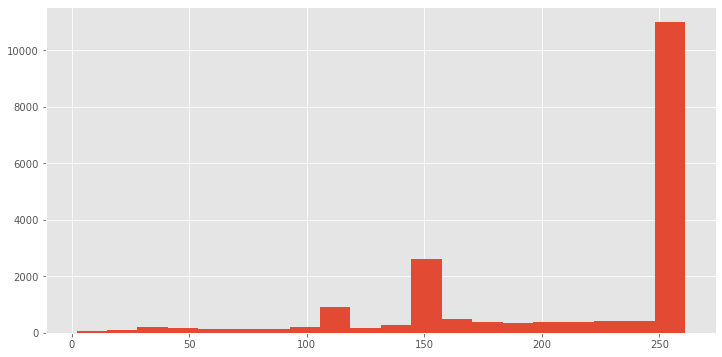

In [12]:
num_by_region = sorted(ts.groupby('RegionID').count()['value'].to_list(), reverse=True)
def display_hist(list):
    mean = statistics.mean(list)
    median = statistics.median(list)
    std = statistics.stdev(list)
    print('Mean: ', mean, '\nMedian: ', median, '\nStanderd Deviation: ', std)
    plt.figure(figsize=(12,6))
    plt.hist(list, bins=20);
display_hist(num_by_region)

Mean:  3351.3855024711697 
Median:  1853.5 
Standerd Deviation:  4664.48703509449


1214

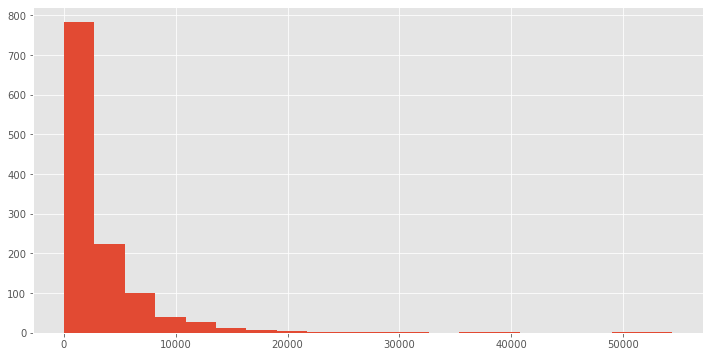

In [13]:
num_by_county = sorted(ts.groupby('CountyName').count()['value'].to_list(), reverse=True)
display_hist(num_by_county)
len(num_by_county)

Mean:  6861.266666666666 
Median:  6501.0 
Standerd Deviation:  1361.8920645652236


150

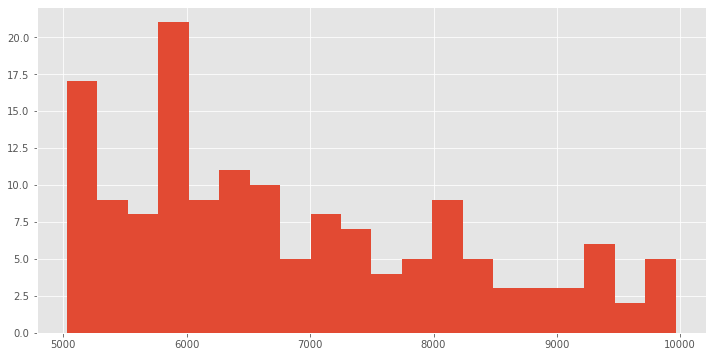

In [14]:
this_list = []
for i in num_by_county:
    if i < 10000 and i > 5000:
        this_list.append(i)

display_hist(this_list)
len(this_list)

Mean:  219.83019686533976 
Median:  261 
Standerd Deviation:  56.56804074639447


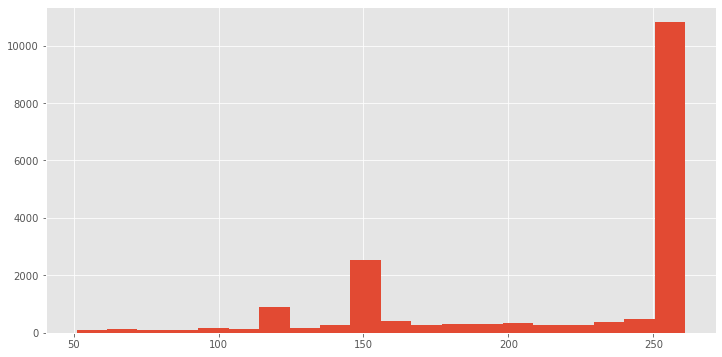

In [15]:
this_list = []
for i in num_by_region:
    if i > 50:
        this_list.append(i)
display_hist(this_list)

In [16]:
chosen_df = ts[ts['time'] == ts['time'].max()]
chosen_df

RegionID RegionType   RegionName  SizeRank StateName State  \
6737900      6181       City     New York         0        NY    NY   
6737901     12447       City  Los Angeles         1        CA    CA   
6737902     39051       City      Houston         2        TX    TX   
6737903     17426       City      Chicago         3        IL    IL   
6737904      6915       City  San Antonio         4        TX    TX   
...           ...        ...          ...       ...       ...   ...   
6763808     43205       City         Tome     29449        NM    NM   
6763809     48550       City       Winton     29449        MN    MN   
6763810     51821       City  Eastabuchie     29449        MS    MS   
6763811    232607       City         Dean     29449        TX    TX   
6763814     11693       City  Great Lakes     30967        IL    IL   

                                    Metro          CountyName       time  \
6737900       New York-Newark-Jersey City       Queens County 2021-09-30   
6737901    Los Angeles-Long Beach-Anaheim  Los Angeles County 2021-09-30   
6737902  Houston-The Woodlands-Sugar Land       Harris County 2021-09-30   
6737903          Chicago-Naperville-Elgin         Cook County 2021-09-30   
6737904         San Antonio-New Braunfels        Bexar County 2021-09-30   
...                                   ...                 ...        ...   
6763808                       Albuquerque     Valencia County 2021-09-30   
6763809                            Duluth  Saint Louis County 2021-09-30   
6763810                            Laurel        Jones County 2021-09-30   
6763811                     Wichita Falls         Clay County 2021-09-30   
6763814          Chicago-Naperville-Elgin         Cook County 2021-09-30   

             value         StateAndCounty  
6737900  1308794.0       NY Queens County  
6737901  1723915.0  CA Los Angeles County  
6737902   433282.0       TX Harris County  
6737903   519673.0         IL Cook County  
6737904   356965.0        TX Bexar County  
...            ...                    ...  
6763808   325556.0     NM Valencia County  
6763809   138277.0  MN Saint Louis County  
6763810   104339.0        MS Jones County  
6763811   309688.0         TX Clay County  
6763814   368277.0         IL Cook County  

[18908 rows x 11 columns]

Mean:  12.719236425037366 
Median:  12.671697953882584 
Standerd Deviation:  0.6796526549125236


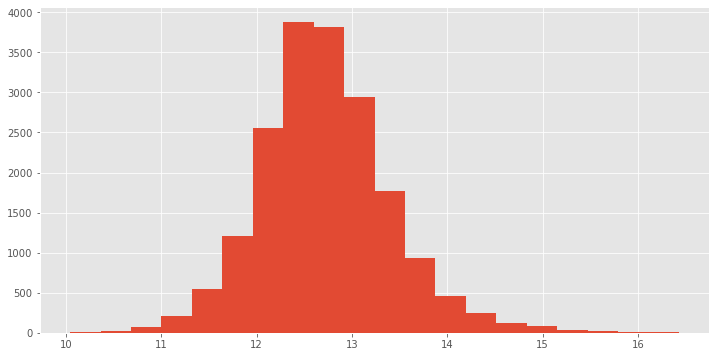

In [17]:
display_hist(np.log(chosen_df.value))

# Filtering Down
I ended up taking the logged values between 12.66925 and 12.67075. Doing so filtered down to 27 counties.

In [18]:
this_df = chosen_df.assign(log_val=np.log(chosen_df.value)).query('log_val >= 12.66925 and log_val <= 12.67075')

In [19]:
this_df.head()

RegionID RegionType    RegionName  SizeRank StateName State  \
6739688     43839       City     Alabaster      1829        AL    AL   
6740381      6333       City   Orange City      2572        FL    FL   
6740458     34247       City    Temperance      2652        MI    MI   
6740959     11725       City    Greenville      3186        MI    MI   
6740978     45508       City  Grand Rapids      3208        MN    MN   

                                      Metro       CountyName       time  \
6739688                   Birmingham-Hoover    Shelby County 2021-09-30   
6740381  Deltona-Daytona Beach-Ormond Beach   Volusia County 2021-09-30   
6740458                              Monroe    Monroe County 2021-09-30   
6740959                Grand Rapids-Wyoming  Montcalm County 2021-09-30   
6740978                        Grand Rapids    Itasca County 2021-09-30   

            value      StateAndCounty    log_val  
6739688  318078.0    AL Shelby County  12.670052  
6740381  317999.0   FL Volusia County  12.669804  
6740458  317954.0    MI Monroe County  12.669662  
6740959  318010.0  MI Montcalm County  12.669838  
6740978  317913.0    MN Itasca County  12.669533

In [20]:
this_df.assign(uid=this_df.State+this_df.CountyName).uid.nunique()

27

In [21]:
this_df.StateAndCounty.nunique(), this_df.CountyName.nunique()

(27, 25)

<AxesSubplot:>

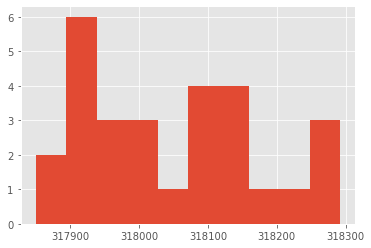

In [22]:
this_df.value.hist()

In [23]:
chosen_countynames = this_df.StateAndCounty.unique()
list(chosen_countynames)


['AL Shelby County',
 'FL Volusia County',
 'MI Monroe County',
 'MI Montcalm County',
 'MN Itasca County',
 'WA Yakima County',
 'AR Washington County',
 'GA Dekalb County',
 'WI Pierce County',
 'PA Allegheny County',
 'MI Saint Clair County',
 'MO Clinton County',
 'IN Shelby County',
 'TN Washington County',
 'KY Bullitt County',
 'ME Penobscot County',
 'IA Benton County',
 'IL Grundy County',
 'TX Collin County',
 'SD Davison County',
 'MO Franklin County',
 'WA Whitman County',
 'SD Turner County',
 'CO Logan County',
 'NJ Salem County',
 'MN Polk County',
 'AZ Mohave County']

In [24]:
ts_bools = ts.StateAndCounty.isin(chosen_countynames)
ts = ts[ts_bools]
ts.head()

RegionID RegionType      RegionName  SizeRank StateName State  \
60      26529       City      Pittsburgh        61        PA    PA   
80      53915       City           Plano        81        TX    TX   
194     32783       City        McKinney       196        TX    TX   
228     18208       City          Frisco       231        TX    TX   
303     41084       City  Stone Mountain       308        GA    GA   

                             Metro        CountyName       time     value  \
60                      Pittsburgh  Allegheny County 2000-01-31  148786.0   
80     Dallas-Fort Worth-Arlington     Collin County 2000-01-31  294580.0   
194    Dallas-Fort Worth-Arlington     Collin County 2000-01-31  279669.0   
228    Dallas-Fort Worth-Arlington     Collin County 2000-01-31  361334.0   
303  Atlanta-Sandy Springs-Roswell     Dekalb County 2000-01-31  197820.0   

          StateAndCounty  
60   PA Allegheny County  
80      TX Collin County  
194     TX Collin County  
228     TX Collin County  
303     GA Dekalb County

In [25]:
get_num_nas(ts)

[{'RegionID': 0},
 {'RegionType': 0},
 {'RegionName': 0},
 {'SizeRank': 0},
 {'StateName': 0},
 {'State': 0},
 {'Metro': 0},
 {'CountyName': 0},
 {'time': 0},
 {'value': 0},
 {'StateAndCounty': 0}]

# One to Many
I used my list of county names to seperate my large dataframe into many small ones, one for each county. I then made each one into a time series where the value corresponds to the average Zestimate for that county. I ended up taking away all data from before 2012 due to the US housing bubble that ended around that time.

In [26]:
ts_list = []
for county in chosen_countynames:
    temp_ts = ts[ts['StateAndCounty'] == county]
    temp_ts = temp_ts.groupby('time').aggregate({'value' :'mean'})
    column_name = county + ' value'
    temp_ts.rename(columns={'value' : column_name}, inplace=True)
#     temp_ts.set_index('time', inplace=True)
    ts_list.append(temp_ts)


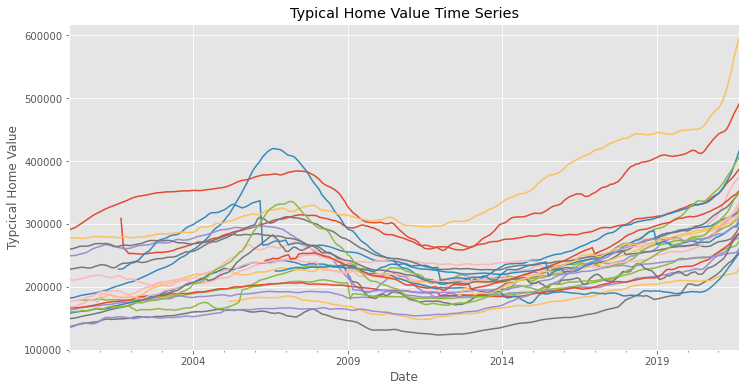

In [27]:
full_ts = pd.concat(ts_list, axis=1)

full_ts.plot(figsize=(12,6), legend=False)
plt.ylabel('Typcical Home Value')
plt.xlabel('Date')
plt.title('Typical Home Value Time Series')
plt.show()

In [28]:
full_ts.describe()
# Back fill NA values or interpolate

AL Shelby County value  FL Volusia County value  \
count              241.000000               261.000000   
mean            290466.139102            276742.661393   
std              26310.314014             63976.156228   
min             251772.411765            182007.315789   
25%             271230.529412            224438.789474   
50%             285910.235294            261389.368421   
75%             307363.352941            319954.000000   
max             387001.941176            419788.526316   

       MI Monroe County value  MI Montcalm County value  \
count              261.000000                261.000000   
mean            245790.782375             156478.274585   
std              35953.105776              25328.098985   
min             182845.733333             123325.333333   
25%             217211.666667             140473.533333   
50%             252521.800000             152484.333333   
75%             272402.066667             162808.000000   
max             319287.866667             255578.066667   

       MN Itasca County value  WA Yakima County value  \
count              199.000000              257.000000   
mean            179262.930653           231777.308212   
std              20028.832034            48306.005046   
min             148058.840000           178446.789474   
25%             163494.580000           200936.210526   
50%             177541.600000           219847.263158   
75%             194029.100000           236438.684211   
max             228683.440000           406271.368421   

       AR Washington County value  GA Dekalb County value  \
count                  261.000000              261.000000   
mean                237179.666521           344410.517241   
std                  37553.780221            48674.261216   
min                 176458.071429           257657.764706   
25%                 210984.466667           307801.588235   
50%                 230499.357143           347826.352941   
75%                 261345.000000           377189.176471   
max                 373219.066667           490626.058824   

       WI Pierce County value  PA Allegheny County value  ...  \
count              242.000000                 261.000000  ...   
mean            261827.223278              194203.207473  ...   
std              32700.523292               19882.587285  ...   
min             219647.400000              163505.576923  ...   
25%             232556.075000              183993.346154  ...   
50%             257495.350000              189012.346154  ...   
75%             283391.425000              198793.018868  ...   
max             336778.000000              277177.830189  ...   

       IL Grundy County value  TX Collin County value  \
count              261.000000              261.000000   
mean            255822.388744           345488.743503   
std              24268.970970            68204.099836   
min             226823.000000           276801.913043   
25%             235011.000000           296761.041667   
50%             250376.181818           315752.708333   
75%             269606.454545           397780.500000   
max             311358.636364           594792.125000   

       SD Davison County value  MO Franklin County value  \
count                91.000000                261.000000   
mean             248531.117216             223367.896083   
std               28455.926224              27404.277862   
min              211110.000000             168128.000000   
25%              223509.000000             209754.500000   
50%              237704.333333             221366.050000   
75%              273131.000000             238738.500000   
max              315253.000000             313807.950000   

       WA Whitman County value  SD Turner County value  CO Logan County value  \
count               185.000000              181.000000             261.000000   
mean             247947.124307           241084.410467          188902.699234   
std 

In [29]:
get_num_nas(full_ts['2012':])

[{'AL Shelby County value': 0},
 {'FL Volusia County value': 0},
 {'MI Monroe County value': 0},
 {'MI Montcalm County value': 0},
 {'MN Itasca County value': 0},
 {'WA Yakima County value': 0},
 {'AR Washington County value': 0},
 {'GA Dekalb County value': 0},
 {'WI Pierce County value': 0},
 {'PA Allegheny County value': 0},
 {'MI Saint Clair County value': 0},
 {'MO Clinton County value': 0},
 {'IN Shelby County value': 0},
 {'TN Washington County value': 0},
 {'KY Bullitt County value': 0},
 {'ME Penobscot County value': 0},
 {'IA Benton County value': 0},
 {'IL Grundy County value': 0},
 {'TX Collin County value': 0},
 {'SD Davison County value': 26},
 {'MO Franklin County value': 0},
 {'WA Whitman County value': 0},
 {'SD Turner County value': 0},
 {'CO Logan County value': 0},
 {'NJ Salem County value': 0},
 {'MN Polk County value': 7},
 {'AZ Mohave County value': 0}]

In [30]:
final_ts = full_ts['2012':]
final_ts.fillna(inplace=True, method='backfill')

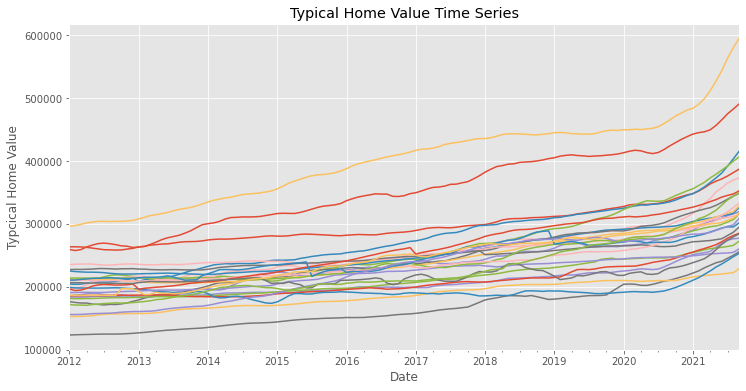

In [31]:
final_ts.plot(figsize=(12,6), legend=False)
plt.ylabel('Typcical Home Value')
plt.xlabel('Date')
plt.title('Typical Home Value Time Series')
plt.show()

# Getting Stationary
My next task was to make the data stationary. I logged the data then subtracted the exponentially weighted mean. Since the data was still showing signs of trends I decided to difference the data with 6 periods. The data was still showing signs of staionarity, so I decided to take the original data and run it through a SARIMAX model instead of a ARIMA.

In [32]:
def stationarity_check(data):
    
    from statsmodels.tsa.stattools import adfuller
    roll_mean = data.rolling(window=8, center=False).mean()
    roll_std = data.rolling(window=8, center=False).std()
    fig = plt.figure(figsize=(12,7))
    plt.plot(data, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    dftest = adfuller(data)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

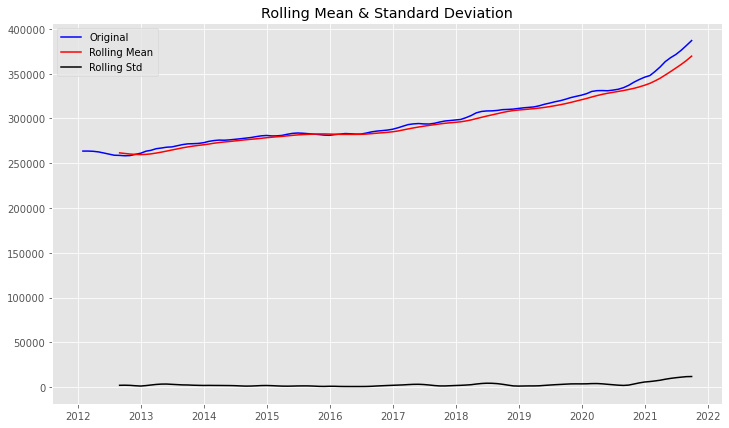

Test Statistic                   2.830826
p-value                          1.000000
#Lags Used                       9.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


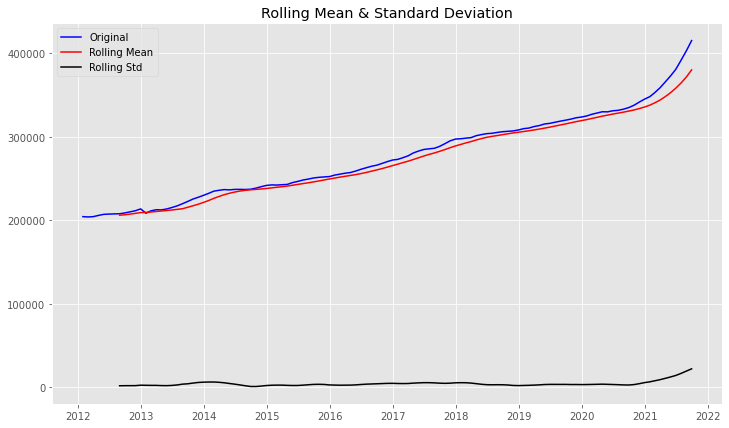

Test Statistic                   1.794603
p-value                          0.998338
#Lags Used                       2.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


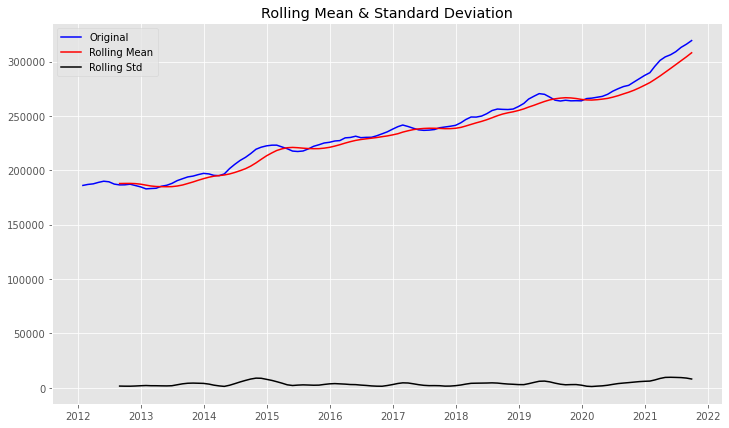

Test Statistic                   0.780616
p-value                          0.991317
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


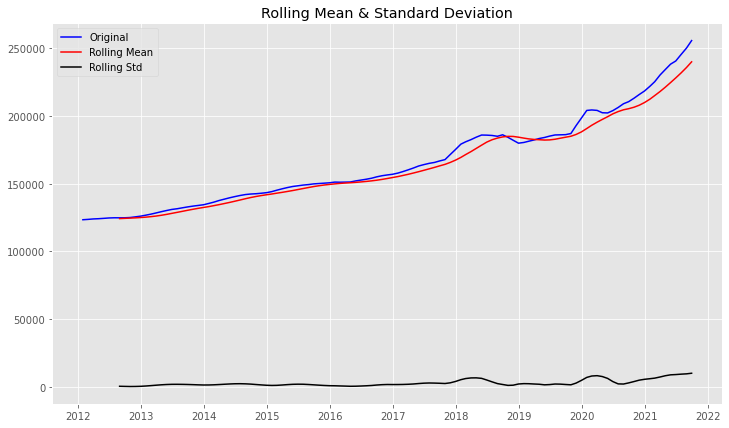

Test Statistic                   2.379369
p-value                          0.999000
#Lags Used                      12.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


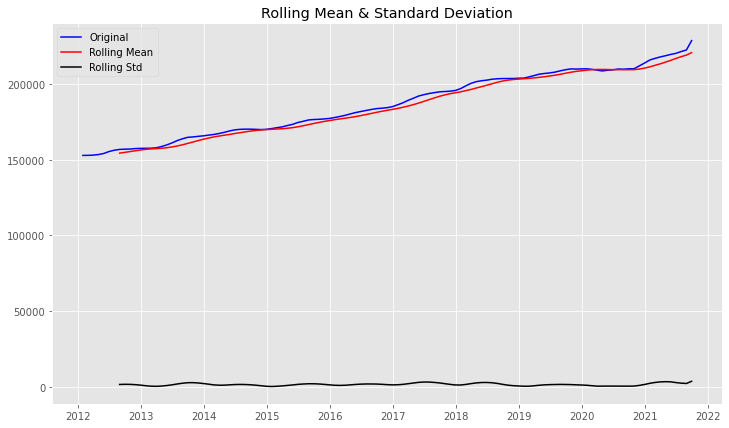

Test Statistic                   1.458848
p-value                          0.997366
#Lags Used                      11.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


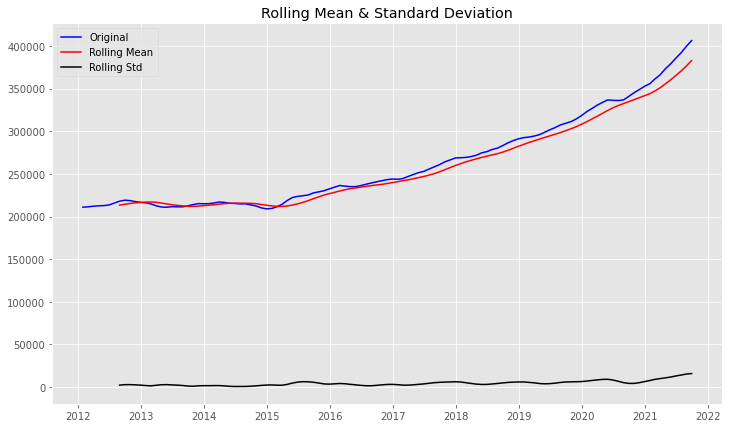

Test Statistic                   2.725751
p-value                          0.999088
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


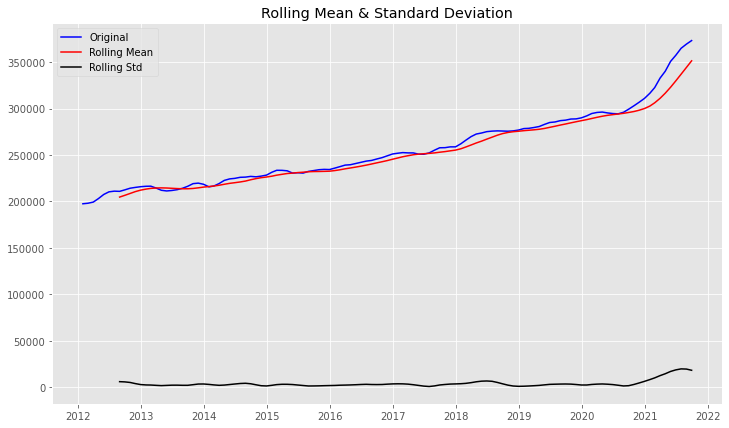

Test Statistic                   2.361836
p-value                          0.998991
#Lags Used                      10.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


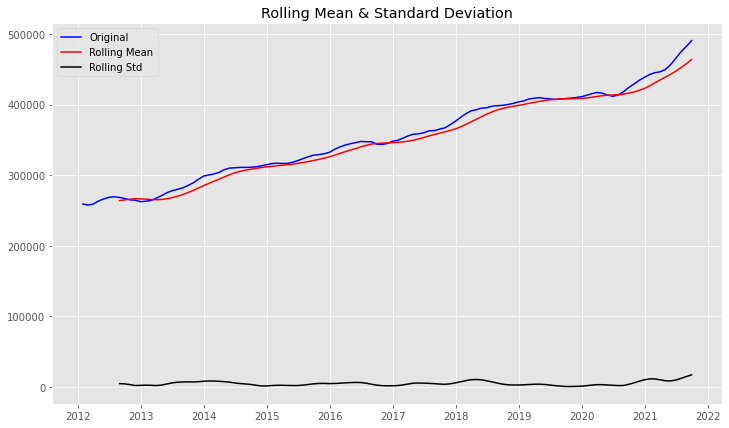

Test Statistic                   1.407307
p-value                          0.997147
#Lags Used                       4.000000
Number of Observations Used    112.000000
Critical Value (1%)             -3.490131
Critical Value (5%)             -2.887712
Critical Value (10%)            -2.580730
dtype: float64


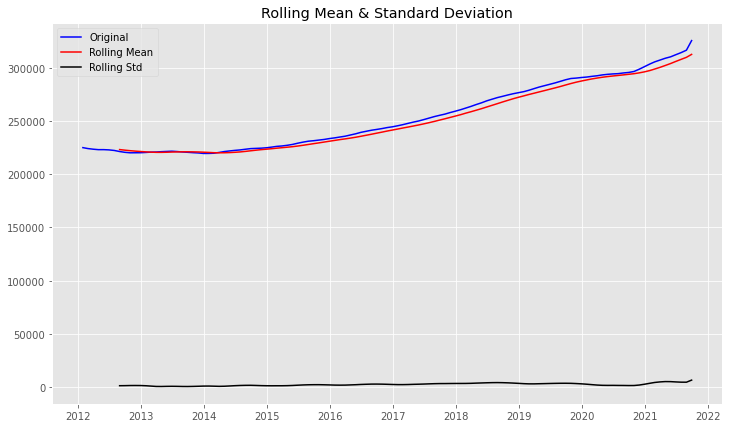

Test Statistic                   1.546849
p-value                          0.997689
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


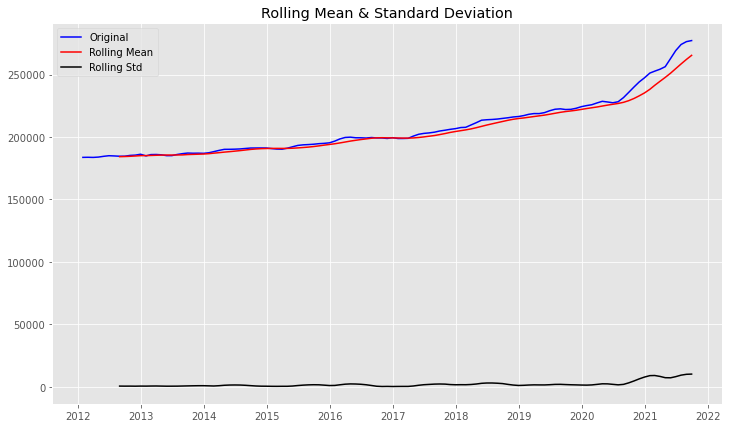

Test Statistic                   3.041321
p-value                          1.000000
#Lags Used                      11.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


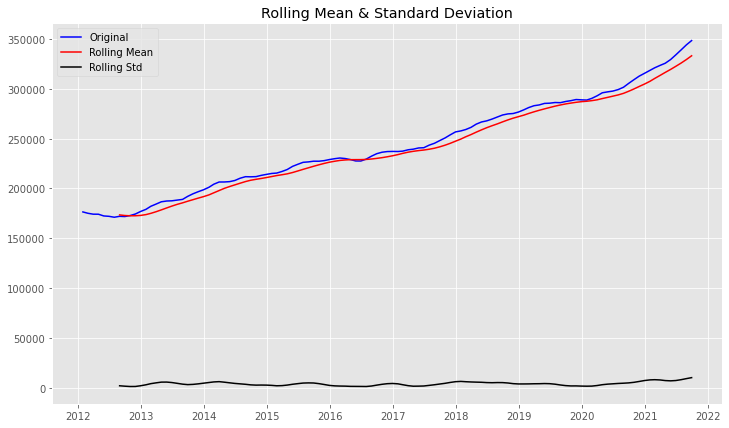

Test Statistic                   1.563312
p-value                          0.997743
#Lags Used                       9.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


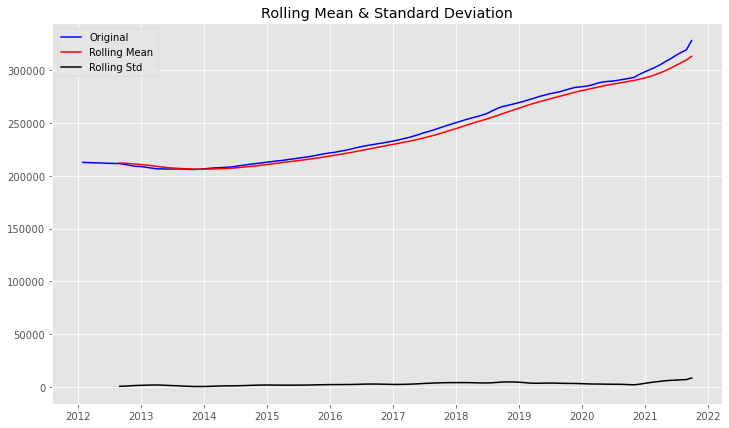

Test Statistic                   2.098871
p-value                          0.998788
#Lags Used                      11.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


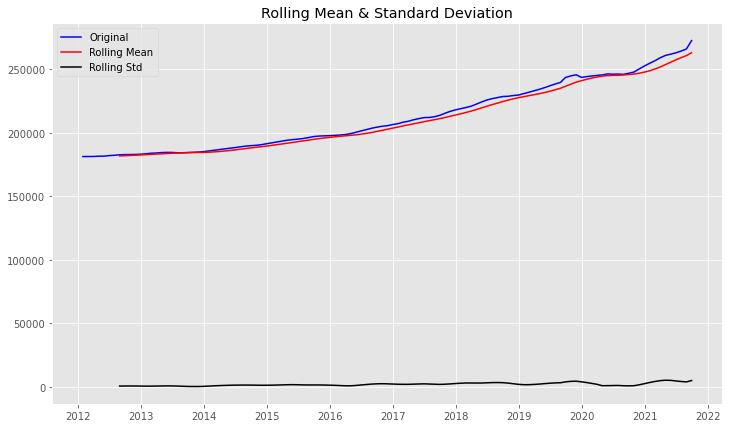

Test Statistic                   2.897875
p-value                          1.000000
#Lags Used                       4.000000
Number of Observations Used    112.000000
Critical Value (1%)             -3.490131
Critical Value (5%)             -2.887712
Critical Value (10%)            -2.580730
dtype: float64


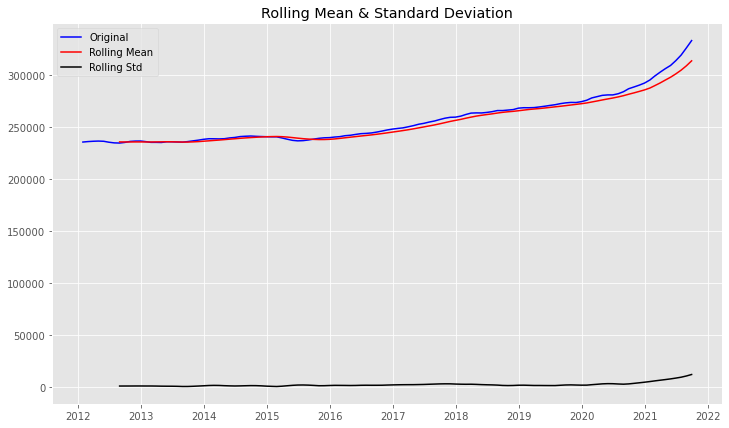

Test Statistic                   1.147936
p-value                          0.995606
#Lags Used                       5.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64


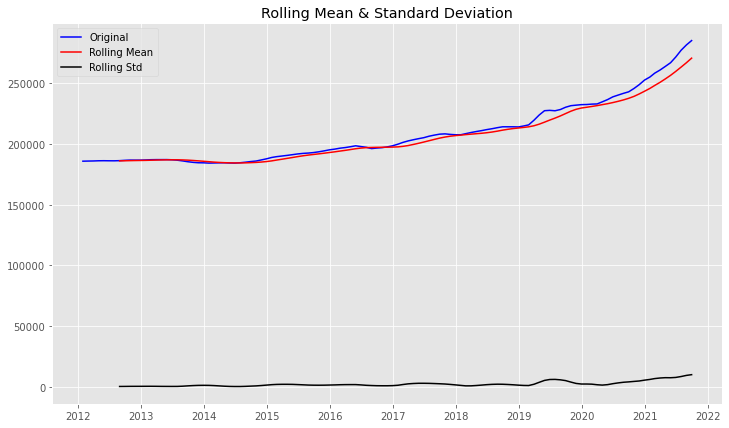

Test Statistic                   3.485710
p-value                          1.000000
#Lags Used                       8.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


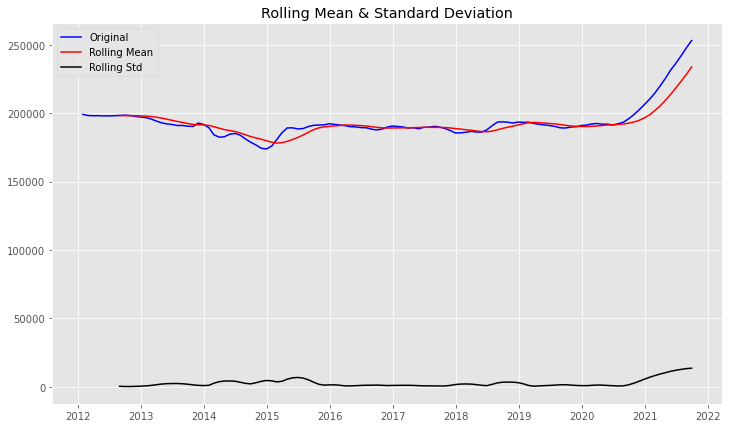

Test Statistic                   0.075200
p-value                          0.964327
#Lags Used                       7.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


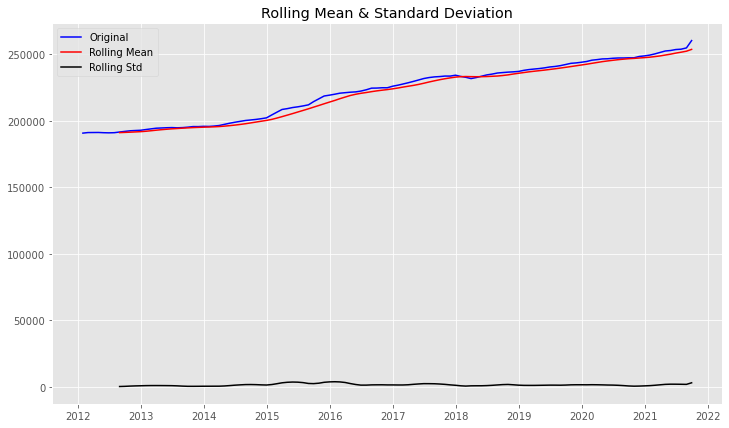

Test Statistic                   0.995114
p-value                          0.994214
#Lags Used                       4.000000
Number of Observations Used    112.000000
Critical Value (1%)             -3.490131
Critical Value (5%)             -2.887712
Critical Value (10%)            -2.580730
dtype: float64


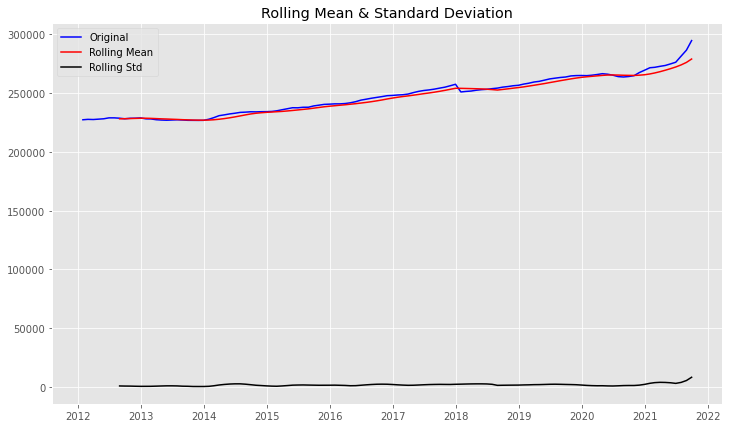

Test Statistic                   1.981398
p-value                          0.998648
#Lags Used                       2.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


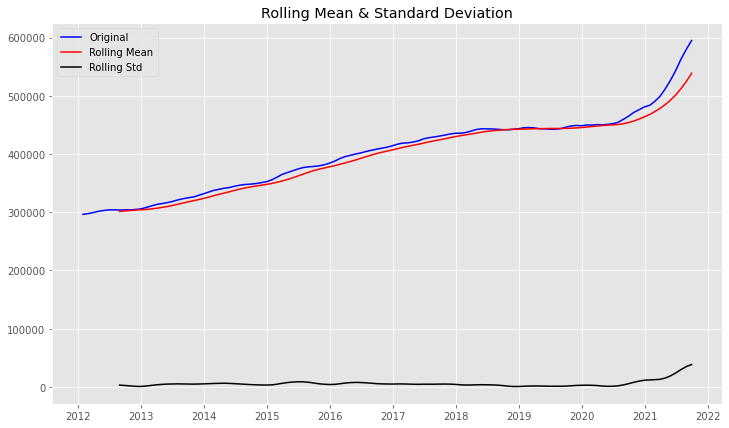

Test Statistic                   0.958856
p-value                          0.993812
#Lags Used                      12.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


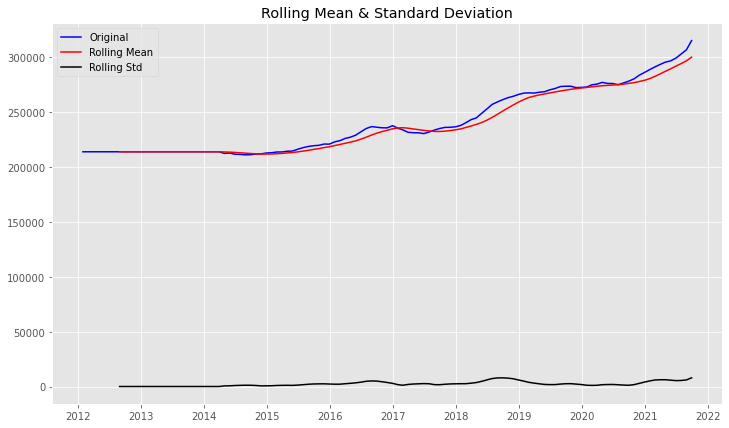

Test Statistic                   2.525949
p-value                          0.999058
#Lags Used                       3.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


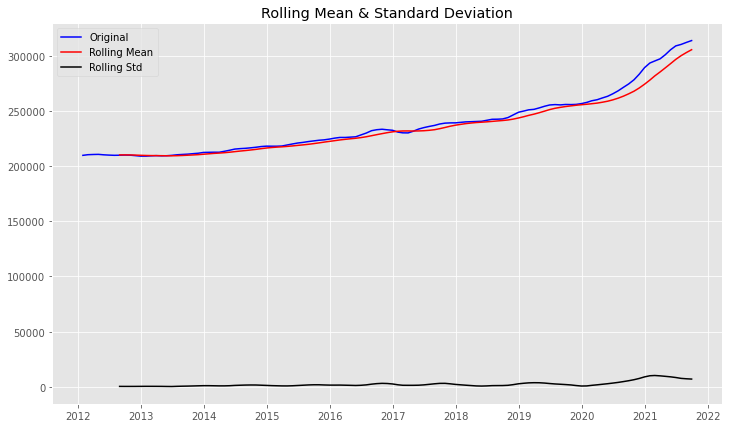

Test Statistic                   2.449925
p-value                          0.999032
#Lags Used                       9.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


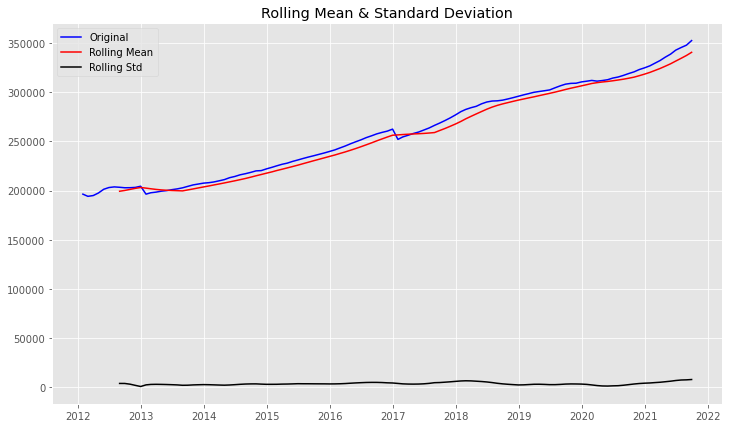

Test Statistic                   2.732388
p-value                          0.999088
#Lags Used                       0.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


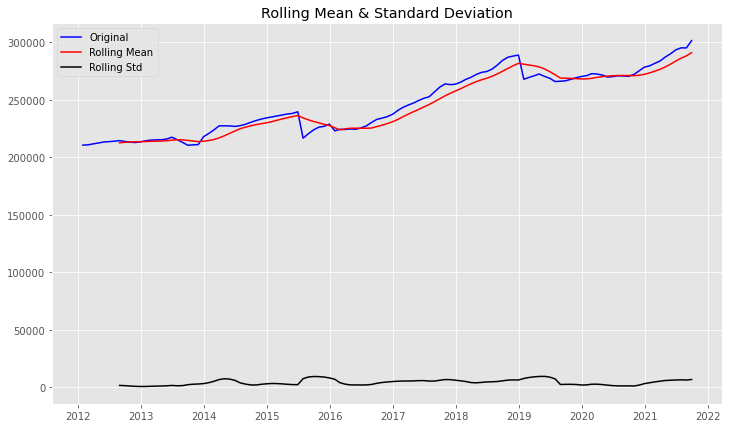

Test Statistic                   0.177422
p-value                          0.970966
#Lags Used                       0.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


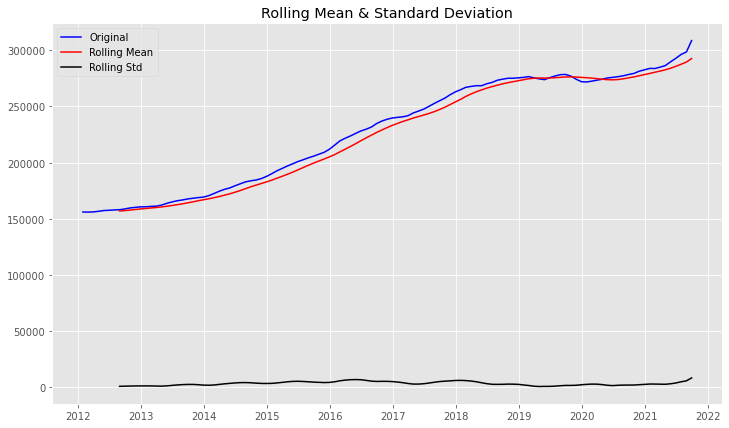

Test Statistic                   0.778573
p-value                          0.991282
#Lags Used                       6.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


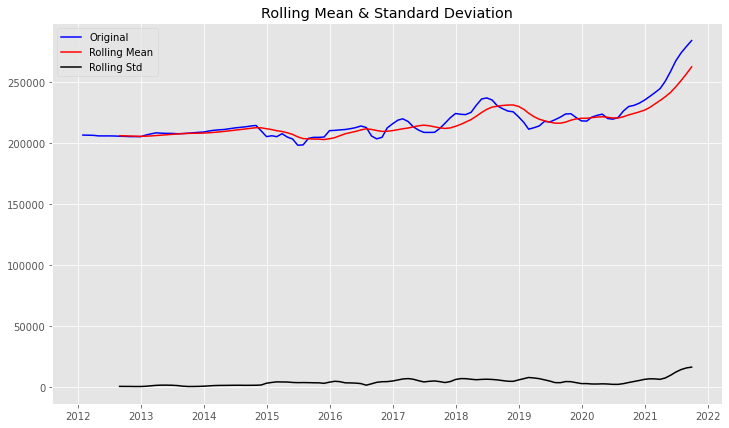

Test Statistic                   1.353286
p-value                          0.996891
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


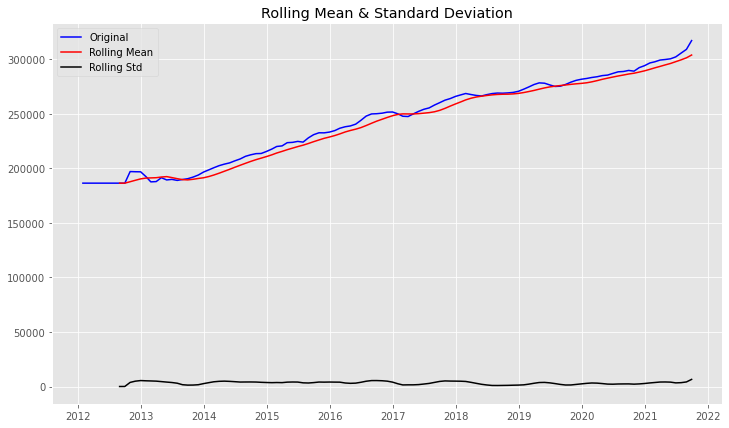

Test Statistic                   0.461226
p-value                          0.983646
#Lags Used                       8.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


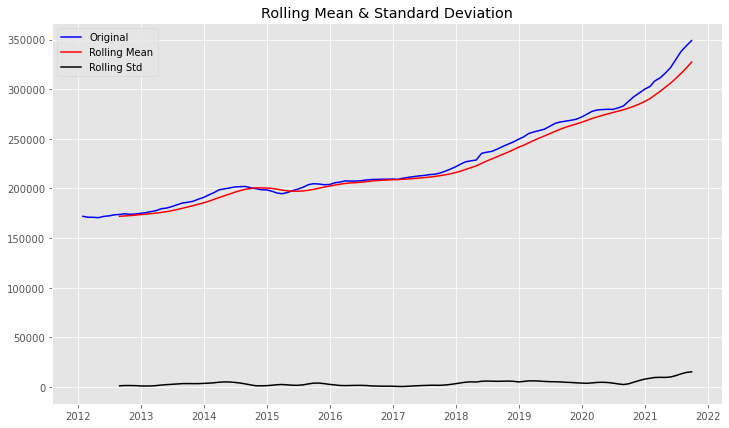

Test Statistic                   3.486827
p-value                          1.000000
#Lags Used                       1.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


In [33]:
for column in final_ts.columns:
    output = stationarity_check(final_ts[column])
    print(output)

In [34]:
ts_log = np.log(final_ts)
roll_mean = ts_log.rolling(window=7, center=False).mean()


<AxesSubplot:xlabel='time'>

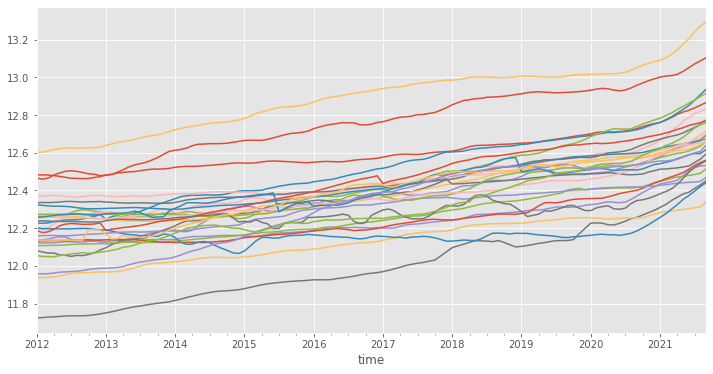

In [35]:
ts_log.plot(figsize=(12,6), legend=False)

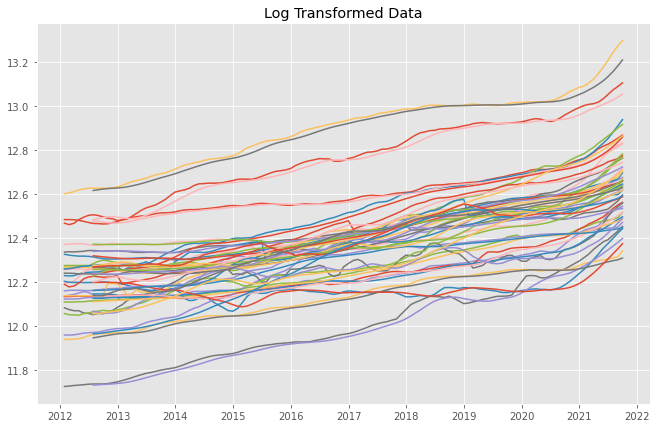

In [36]:
fig = plt.figure(figsize=(11,7)) 
plt.plot(ts_log, label='Original')
plt.plot(roll_mean, label='Rolling Mean')
# plt.legend(loc='best')
plt.title('Log Transformed Data')
plt.show(block=False)

<AxesSubplot:xlabel='time'>

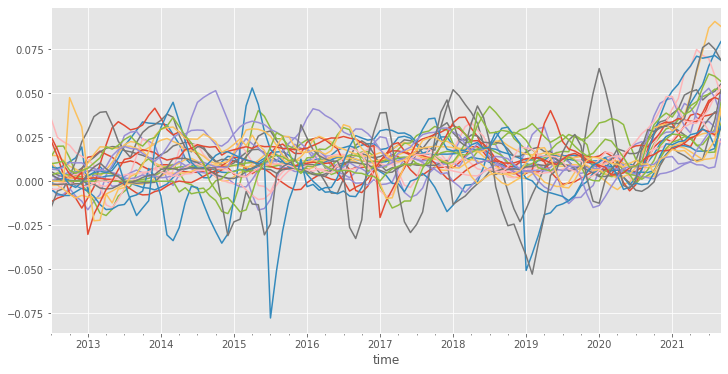

In [37]:
data_minus_roll_mean = ts_log - roll_mean
data_minus_roll_mean.dropna(inplace=True)
data_minus_roll_mean.plot(figsize=(12,6), legend=False)

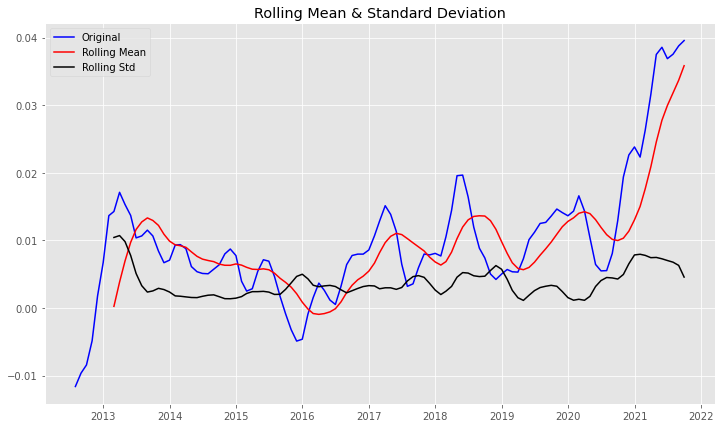

Test Statistic                   0.638805
p-value                          0.988534
#Lags Used                       9.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


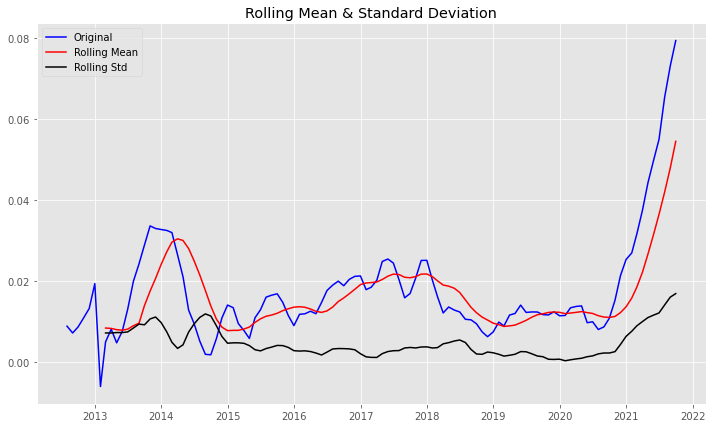

Test Statistic                  -0.130230
p-value                          0.946343
#Lags Used                       4.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


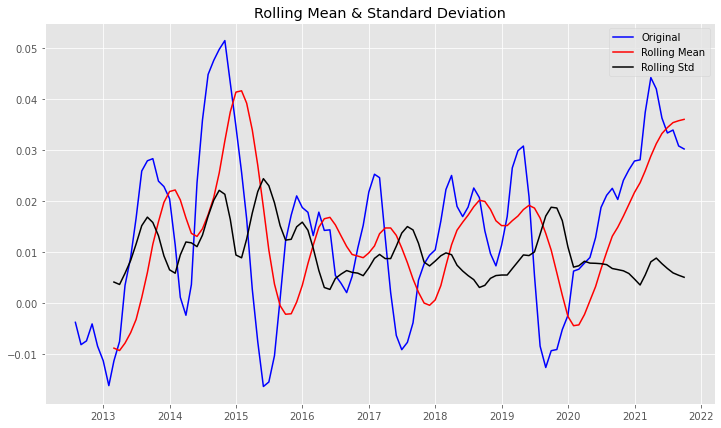

Test Statistic                 -3.259202
p-value                         0.016804
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


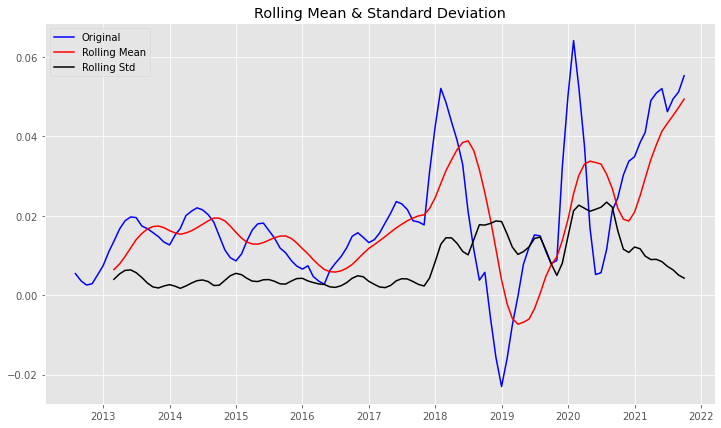

Test Statistic                 -0.975609
p-value                         0.762056
#Lags Used                     11.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


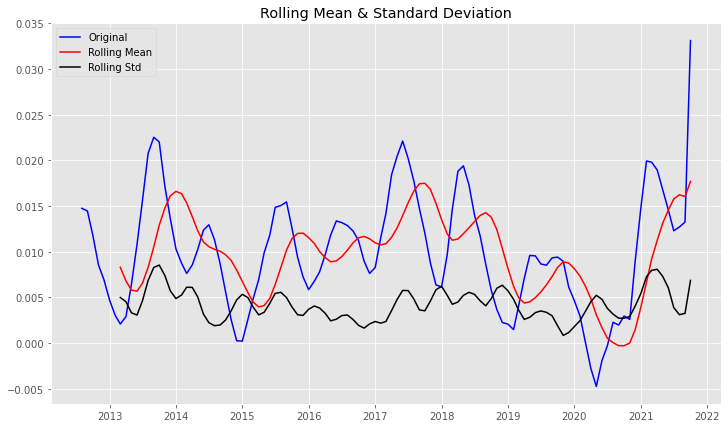

Test Statistic                 -1.349527
p-value                         0.606220
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


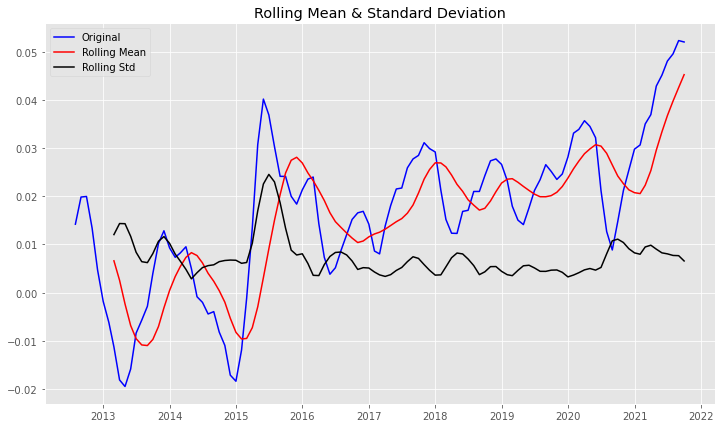

Test Statistic                 -0.667317
p-value                         0.855035
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


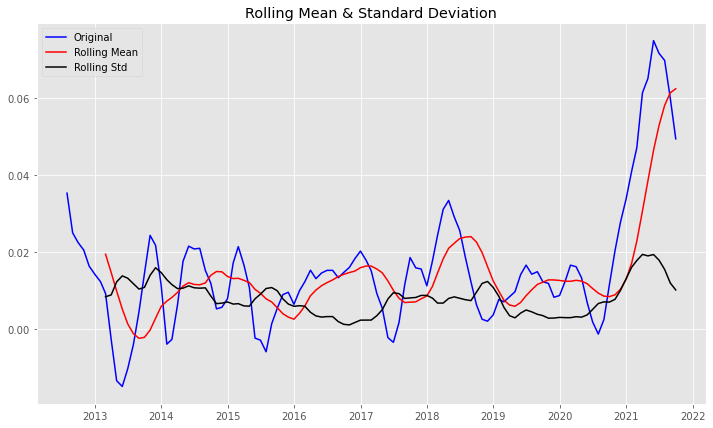

Test Statistic                  -3.160196
p-value                          0.022407
#Lags Used                       7.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


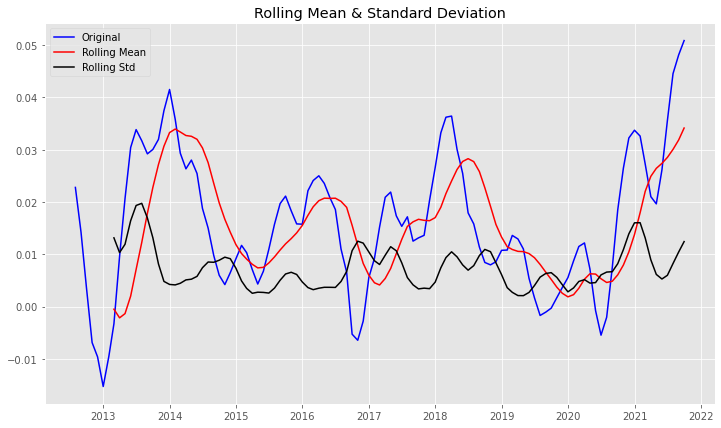

Test Statistic                 -3.599988
p-value                         0.005761
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


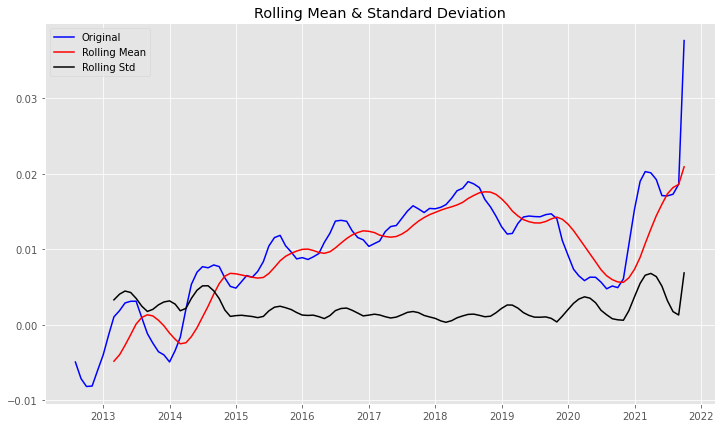

Test Statistic                  0.724068
p-value                         0.990306
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


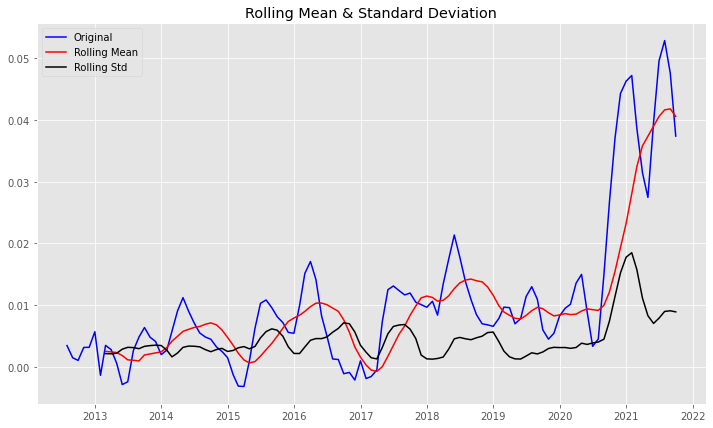

Test Statistic                  -1.579297
p-value                          0.493985
#Lags Used                       7.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


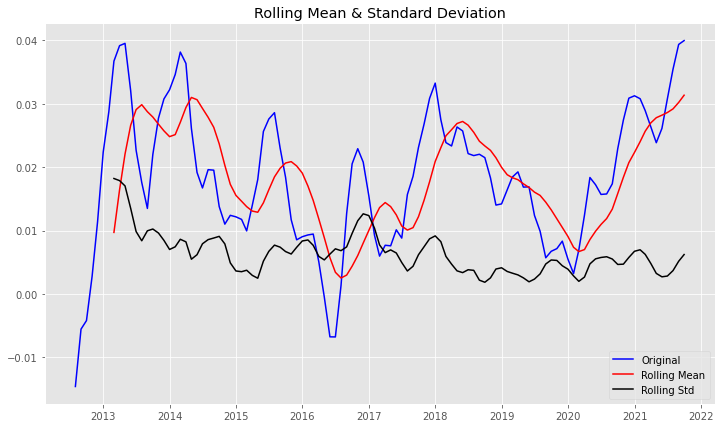

Test Statistic                 -2.383853
p-value                         0.146346
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


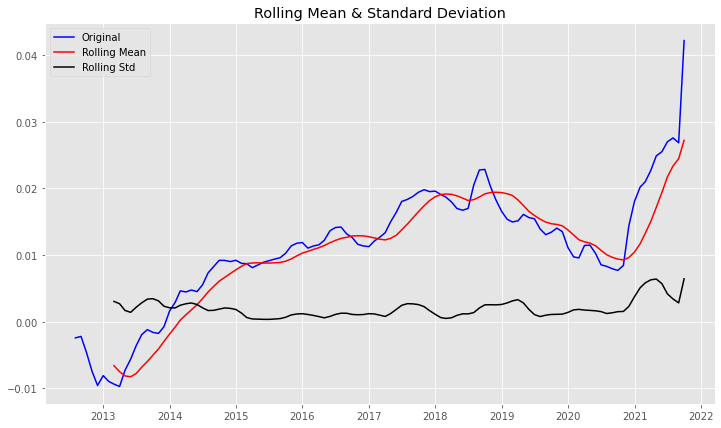

Test Statistic                  0.743768
p-value                         0.990672
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


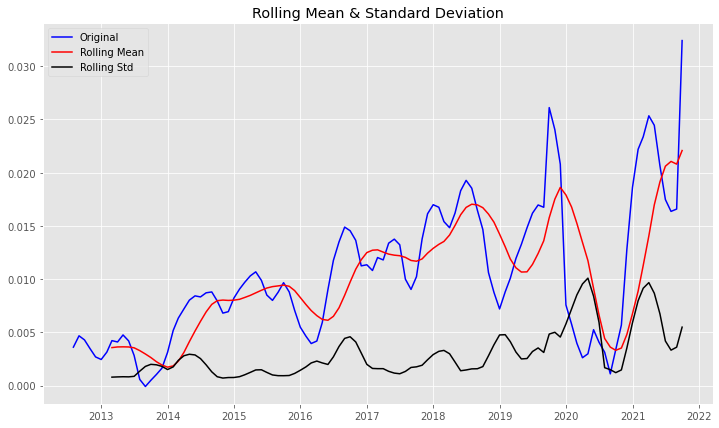

Test Statistic                  -0.875127
p-value                          0.796053
#Lags Used                       3.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


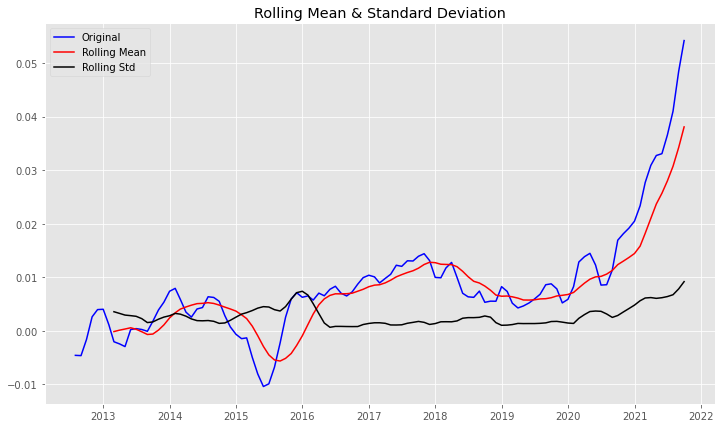

Test Statistic                   1.399085
p-value                          0.997110
#Lags Used                       8.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


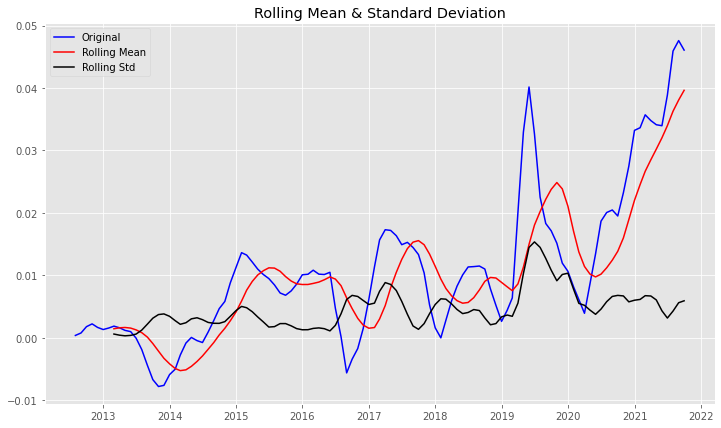

Test Statistic                   0.169606
p-value                          0.970504
#Lags Used                      10.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64


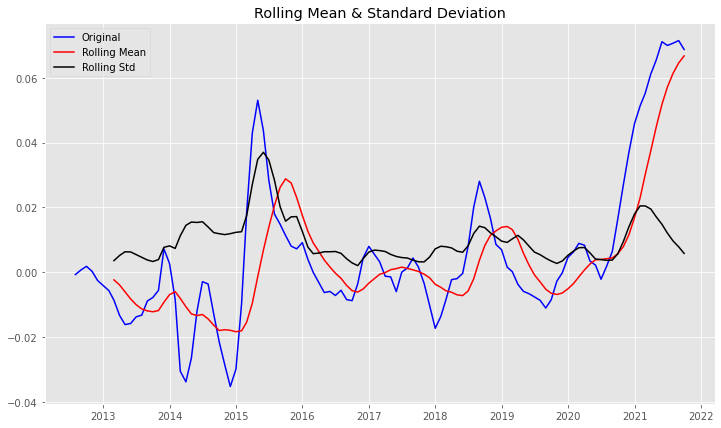

Test Statistic                  -1.360956
p-value                          0.600844
#Lags Used                       7.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


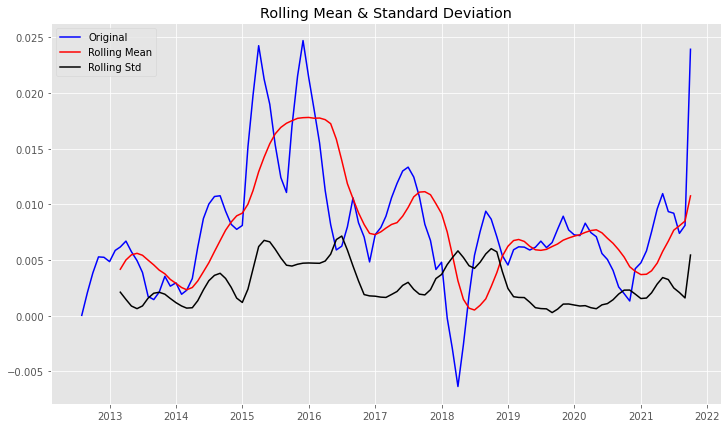

Test Statistic                  -1.447265
p-value                          0.559419
#Lags Used                       3.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


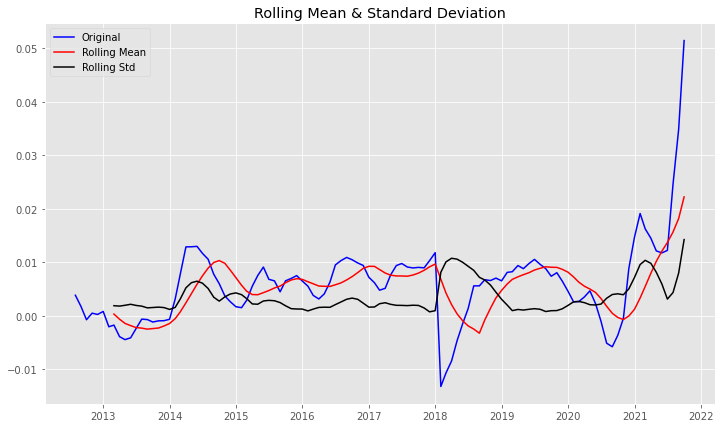

Test Statistic                  -1.345738
p-value                          0.607996
#Lags Used                       2.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


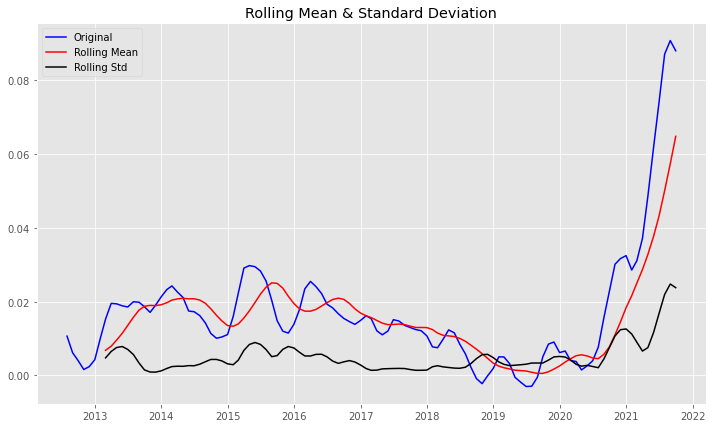

Test Statistic                  -1.239628
p-value                          0.656321
#Lags Used                       9.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


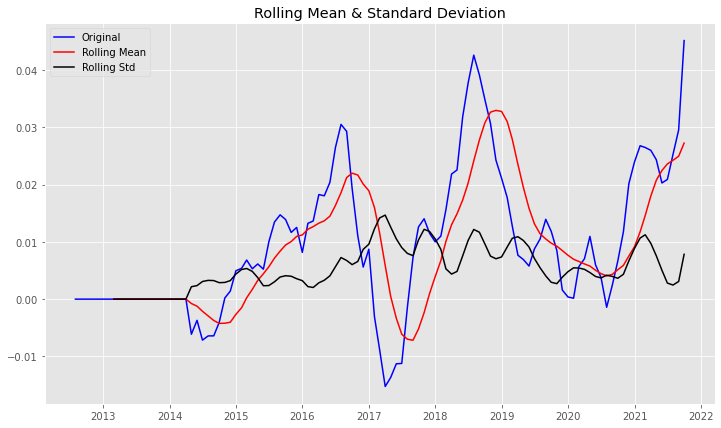

Test Statistic                  -1.478716
p-value                          0.544013
#Lags Used                       3.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


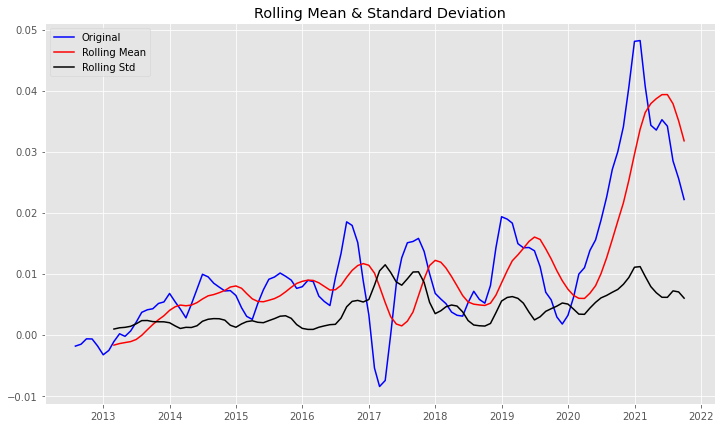

Test Statistic                  -2.146338
p-value                          0.226295
#Lags Used                       7.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


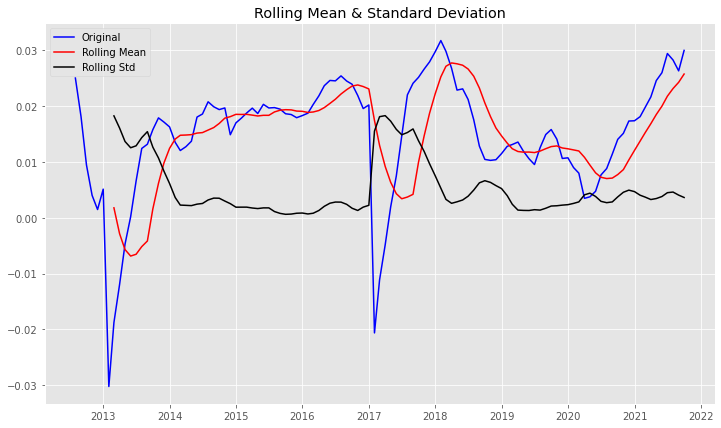

Test Statistic                  -3.068196
p-value                          0.028998
#Lags Used                       0.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


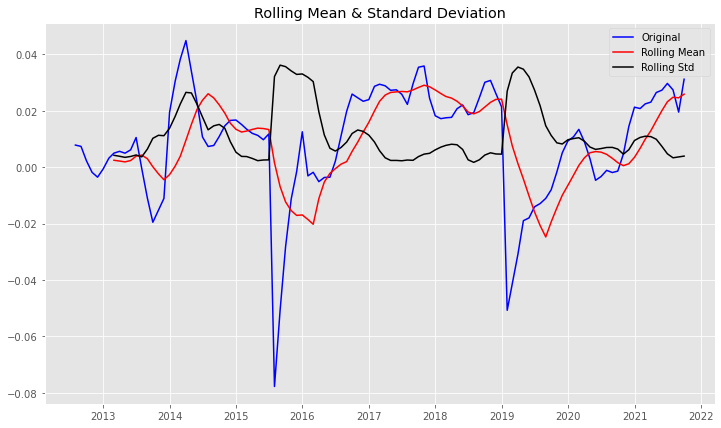

Test Statistic                  -3.586485
p-value                          0.006025
#Lags Used                       0.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


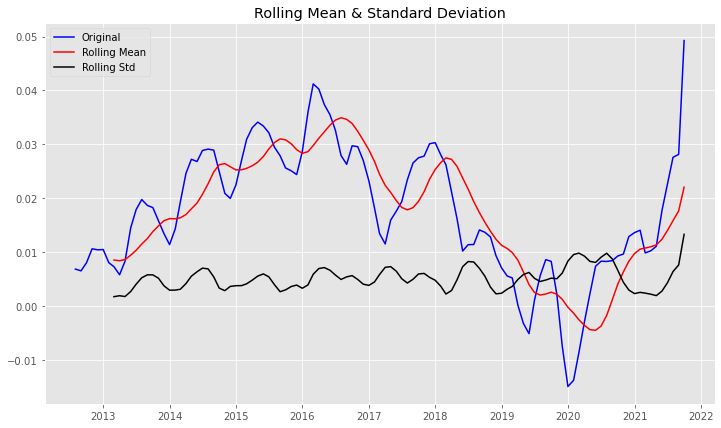

Test Statistic                  -1.090059
p-value                          0.719020
#Lags Used                       6.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


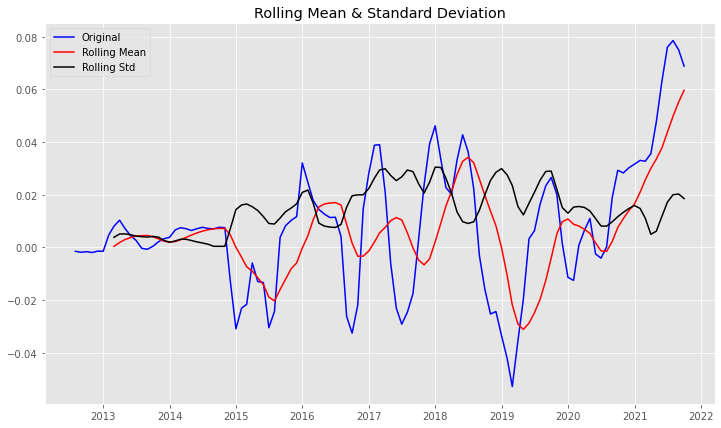

Test Statistic                 -0.927407
p-value                         0.778813
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


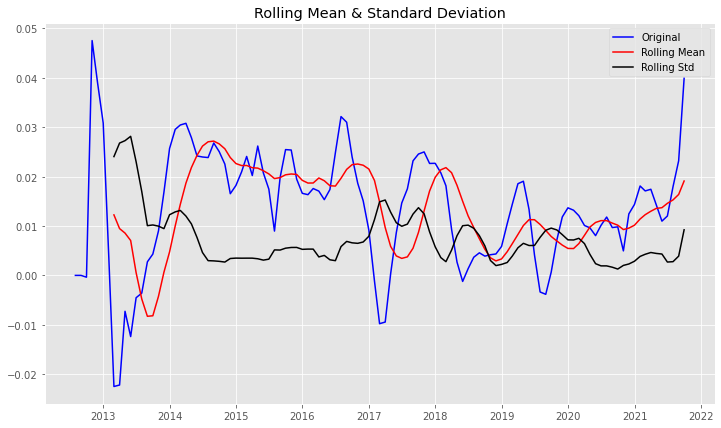

Test Statistic                  -2.921333
p-value                          0.042923
#Lags Used                       4.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


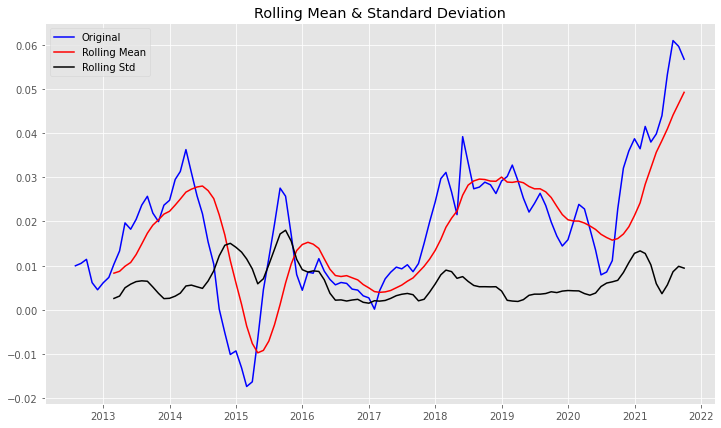

Test Statistic                  -2.125145
p-value                          0.234524
#Lags Used                       1.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


In [38]:
for column in data_minus_roll_mean.columns:
    output = stationarity_check(data_minus_roll_mean[column])
    print(output)

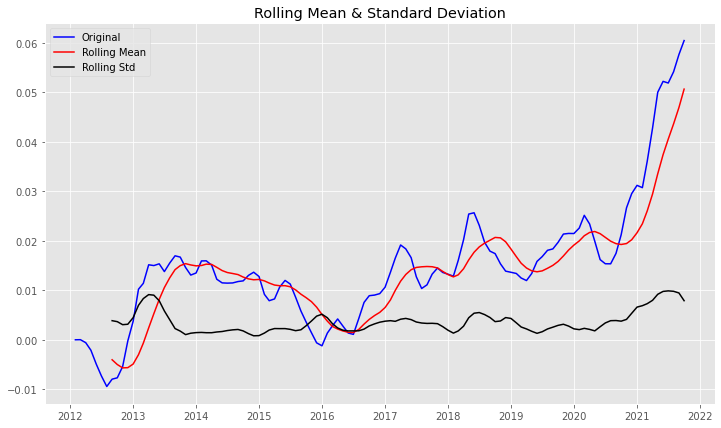

Test Statistic                   0.274586
p-value                          0.976148
#Lags Used                       9.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


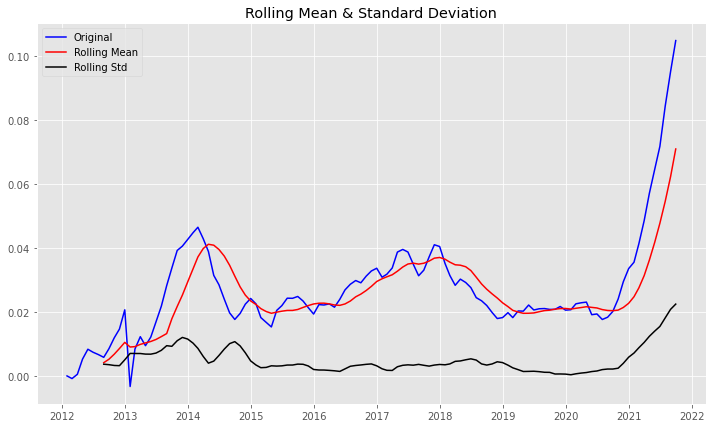

Test Statistic                   1.317878
p-value                          0.996707
#Lags Used                       1.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


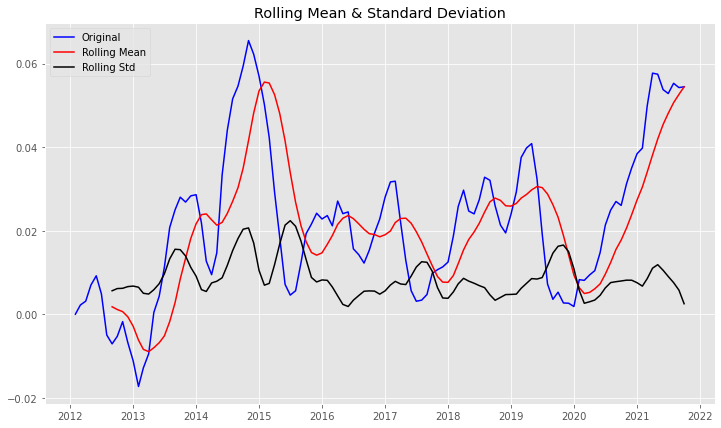

Test Statistic                  -3.403010
p-value                          0.010857
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


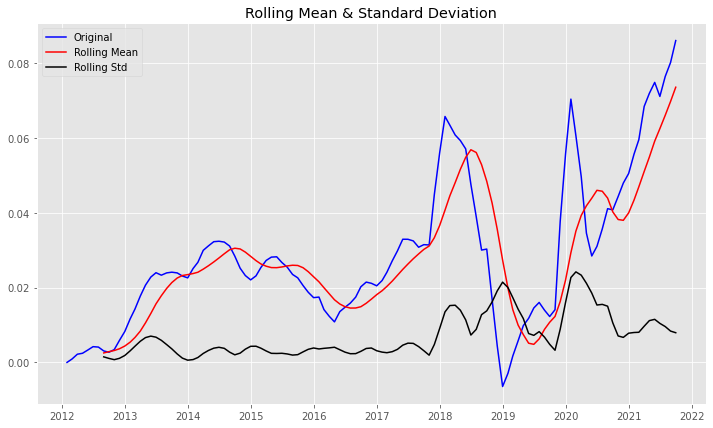

Test Statistic                  -0.749269
p-value                          0.833572
#Lags Used                      11.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


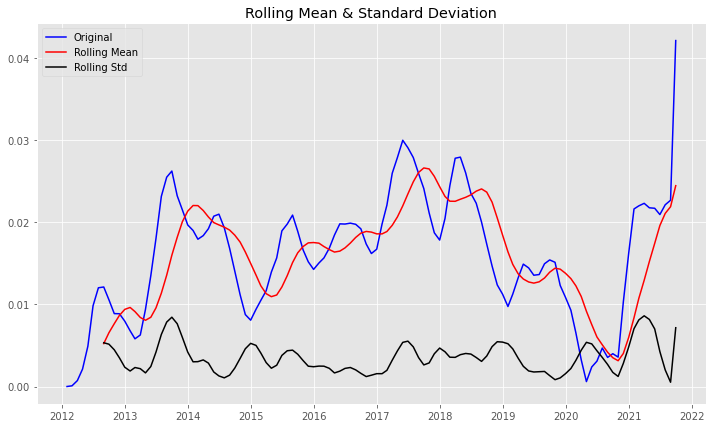

Test Statistic                  -1.821547
p-value                          0.369818
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


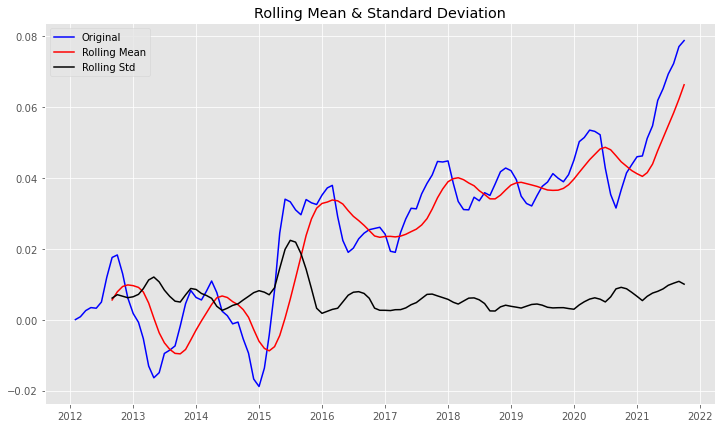

Test Statistic                  -0.078094
p-value                          0.951577
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


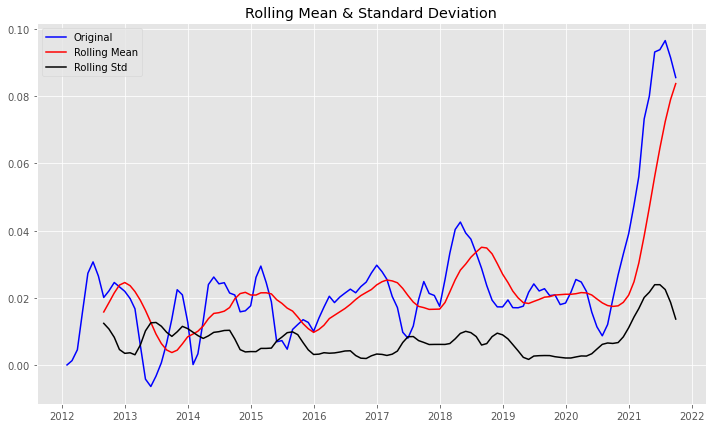

Test Statistic                  -2.124965
p-value                          0.234595
#Lags Used                       7.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


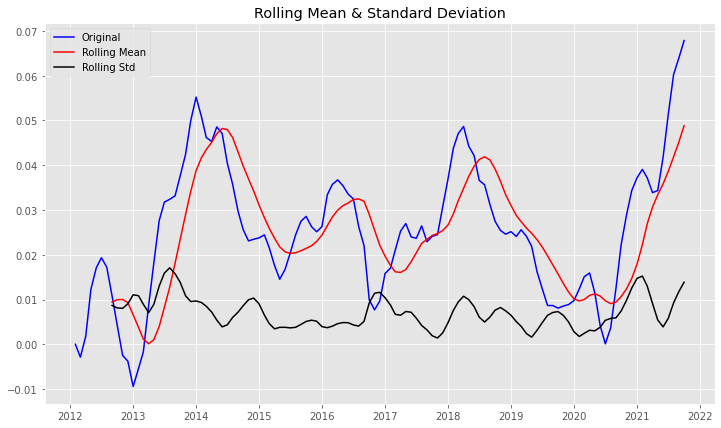

Test Statistic                  -4.456230
p-value                          0.000236
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


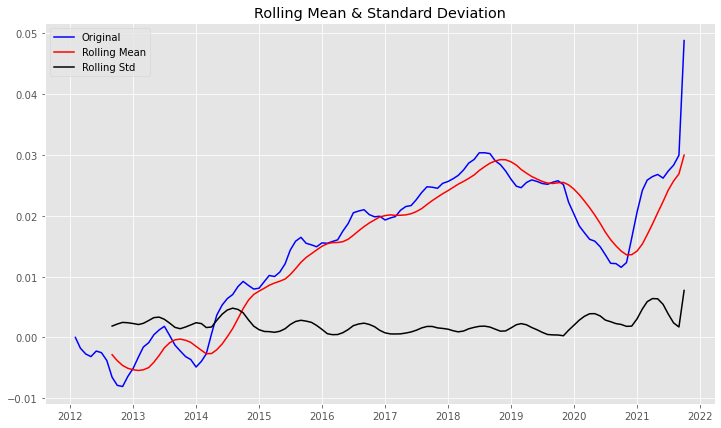

Test Statistic                   0.584757
p-value                          0.987234
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


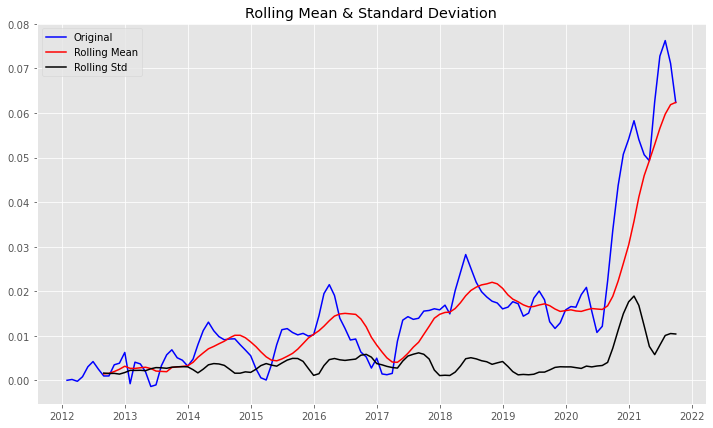

Test Statistic                   0.448414
p-value                          0.983218
#Lags Used                      11.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


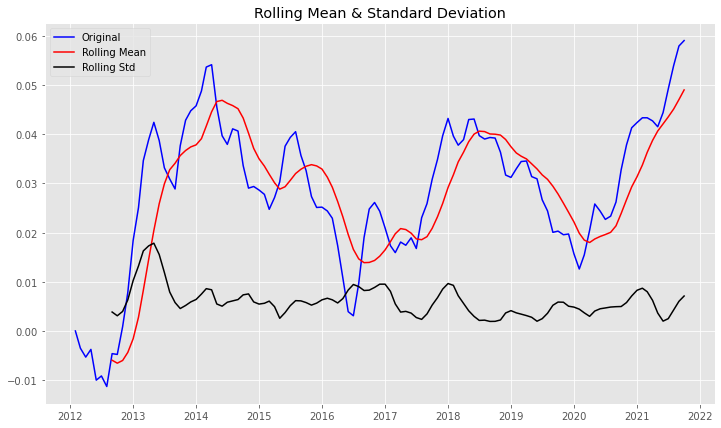

Test Statistic                  -2.377644
p-value                          0.148146
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


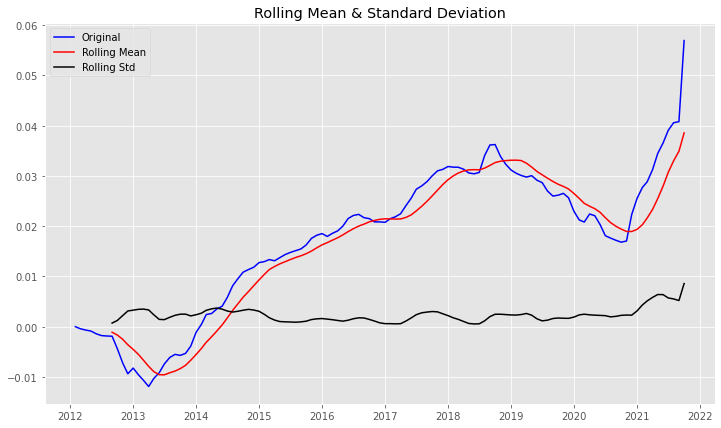

Test Statistic                  -0.046936
p-value                          0.954474
#Lags Used                      11.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


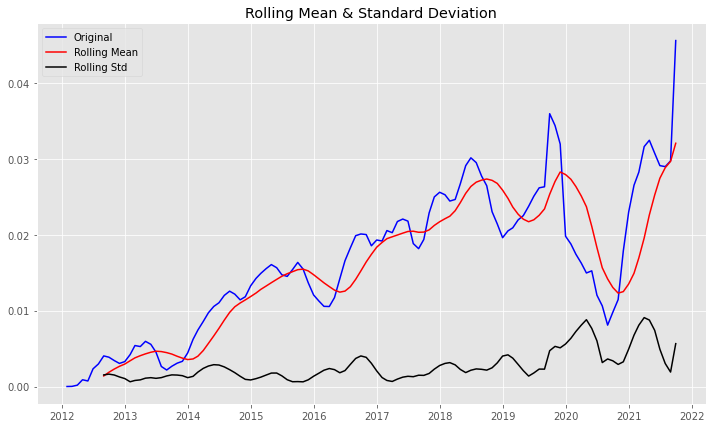

Test Statistic                  -0.403509
p-value                          0.909511
#Lags Used                       4.000000
Number of Observations Used    112.000000
Critical Value (1%)             -3.490131
Critical Value (5%)             -2.887712
Critical Value (10%)            -2.580730
dtype: float64


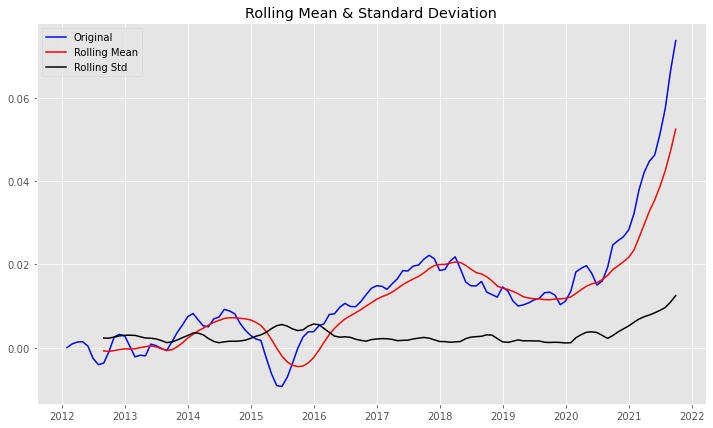

Test Statistic                   0.998096
p-value                          0.994246
#Lags Used                       7.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


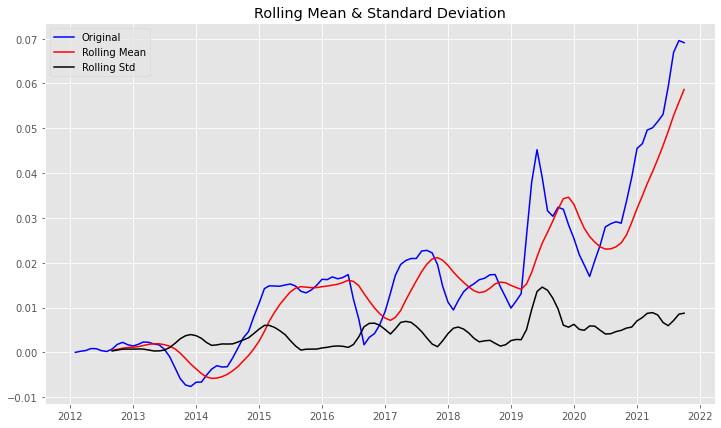

Test Statistic                   1.248021
p-value                          0.996301
#Lags Used                       9.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


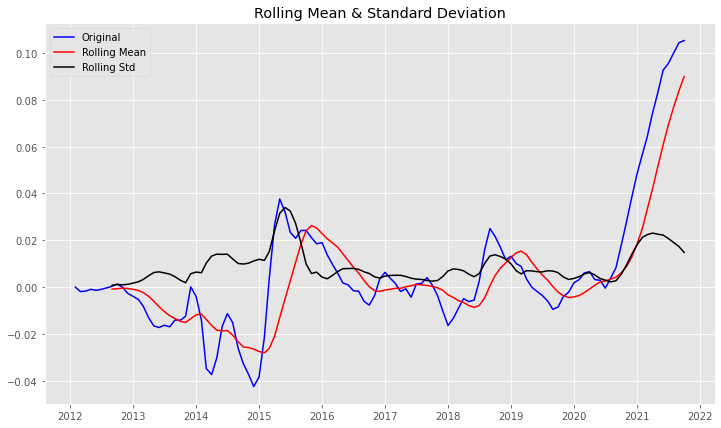

Test Statistic                  -0.717847
p-value                          0.842072
#Lags Used                       7.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


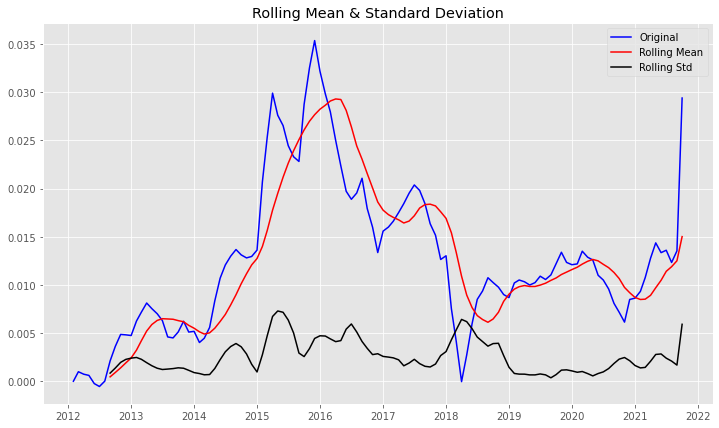

Test Statistic                  -1.259538
p-value                          0.647475
#Lags Used                       3.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


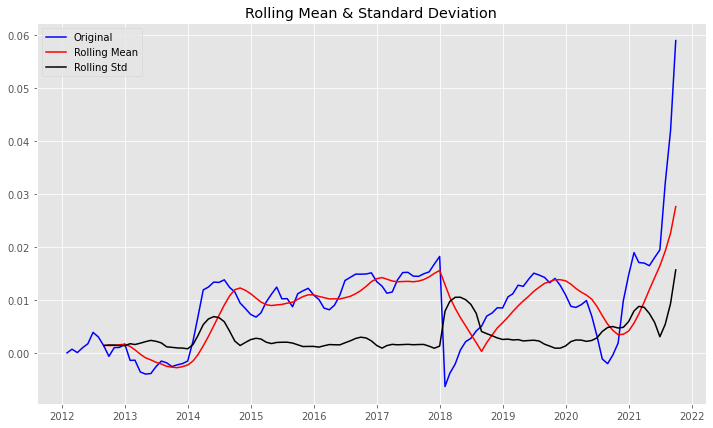

Test Statistic                  -0.263973
p-value                          0.930454
#Lags Used                       2.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


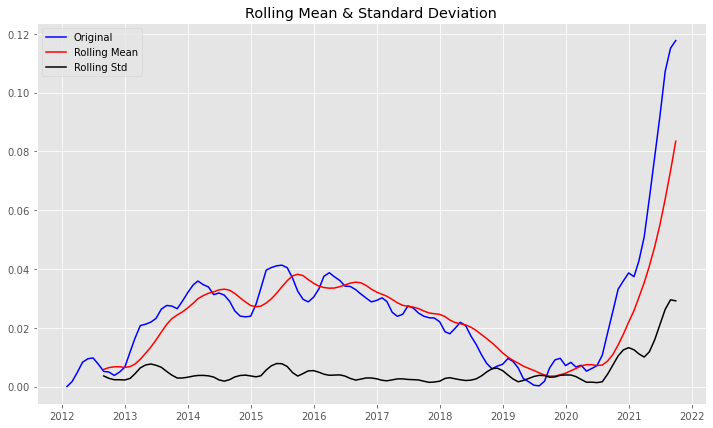

Test Statistic                  -1.972034
p-value                          0.298968
#Lags Used                       9.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


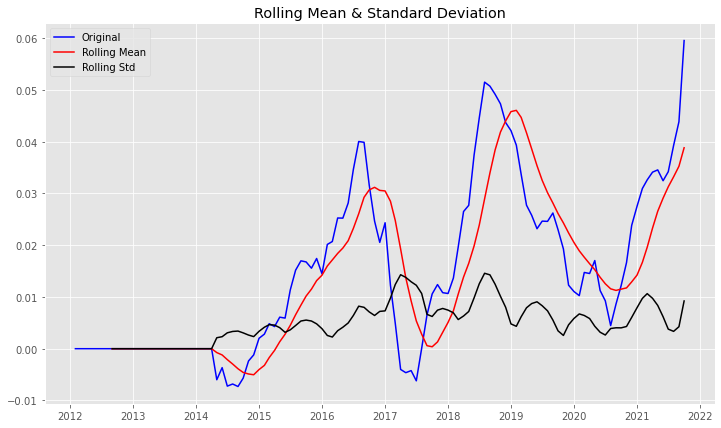

Test Statistic                  -0.921472
p-value                          0.780819
#Lags Used                       6.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


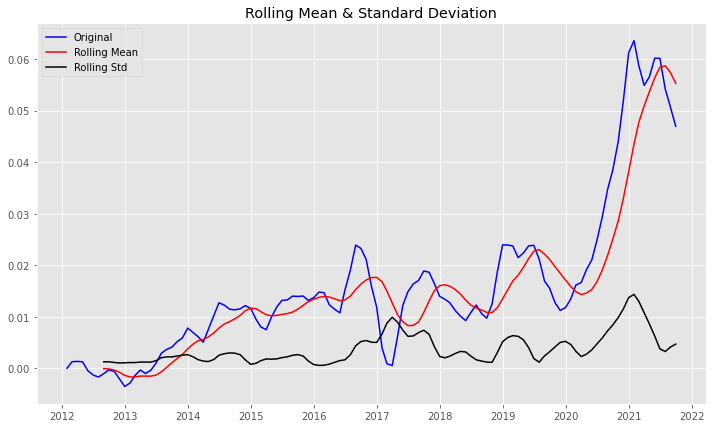

Test Statistic                  -1.170380
p-value                          0.686206
#Lags Used                       7.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


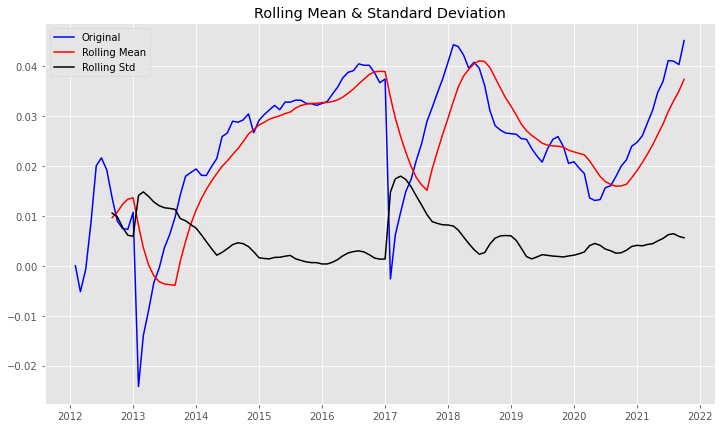

Test Statistic                  -2.498126
p-value                          0.115931
#Lags Used                       0.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


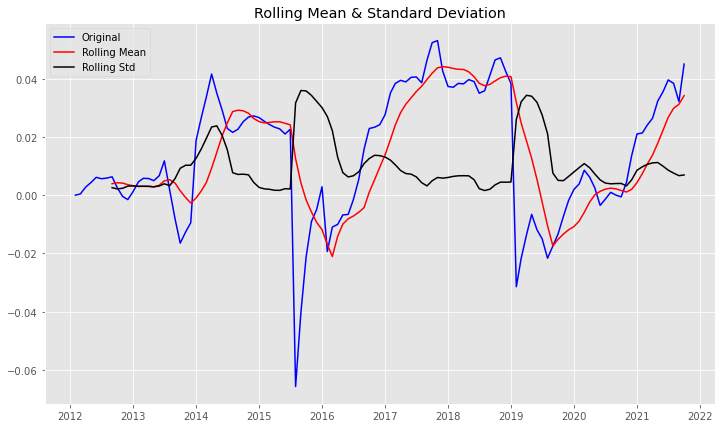

Test Statistic                  -2.972459
p-value                          0.037548
#Lags Used                       0.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


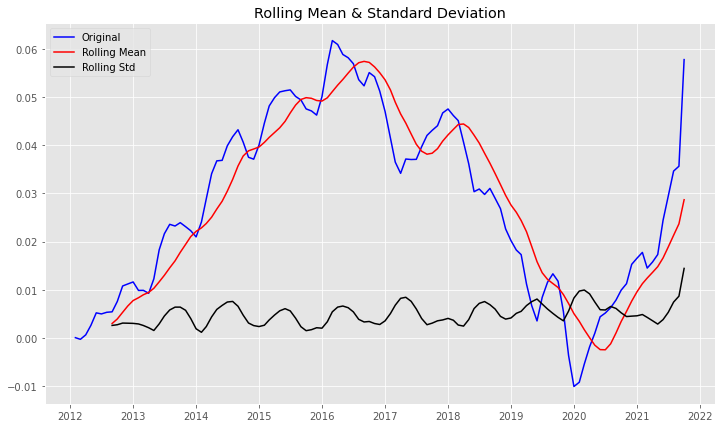

Test Statistic                  -2.078502
p-value                          0.253246
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


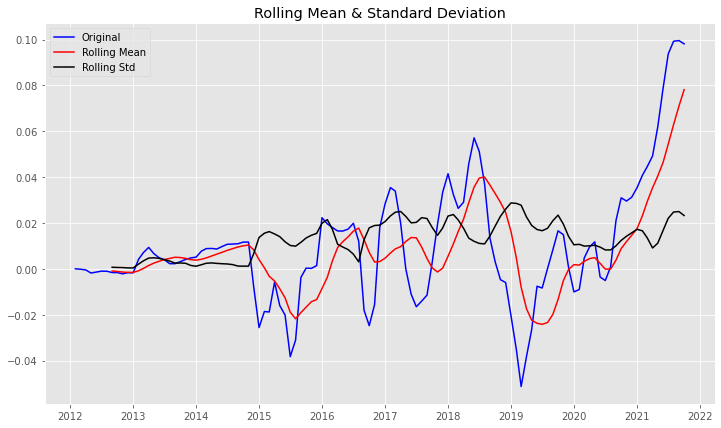

Test Statistic                  -0.591642
p-value                          0.872859
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


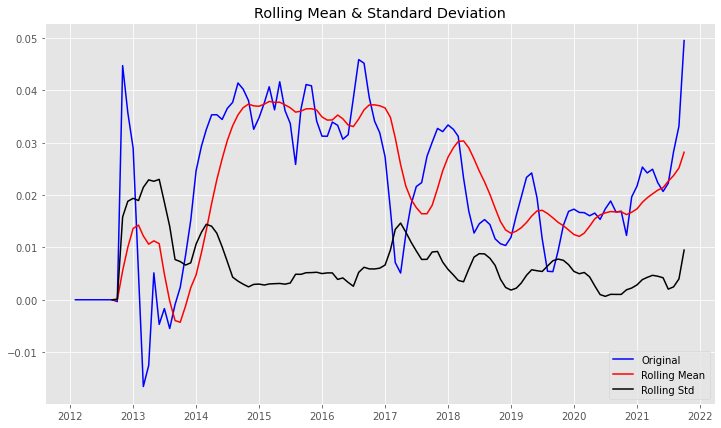

Test Statistic                  -2.484865
p-value                          0.119200
#Lags Used                       8.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


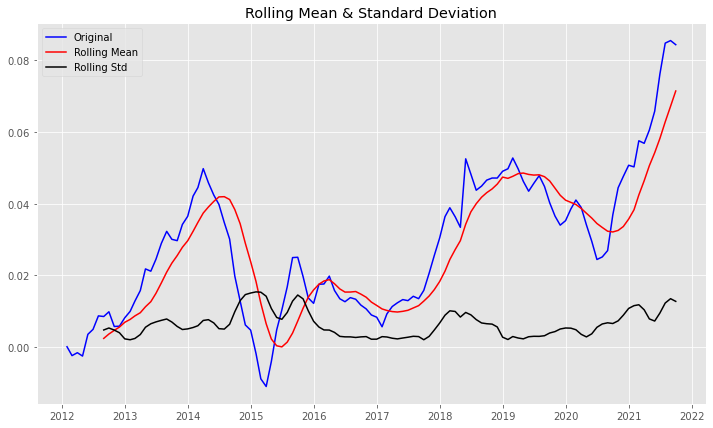

Test Statistic                  -1.215654
p-value                          0.666826
#Lags Used                       1.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


In [39]:
exp_roll_mean = ts_log.ewm(halflife=4).mean()
data_minus_exp_roll_mean = ts_log - exp_roll_mean
data_minus_exp_roll_mean.dropna(inplace=True)
for column in data_minus_exp_roll_mean.columns:
    output = stationarity_check(data_minus_exp_roll_mean[column])
    print(output)

<AxesSubplot:xlabel='time'>

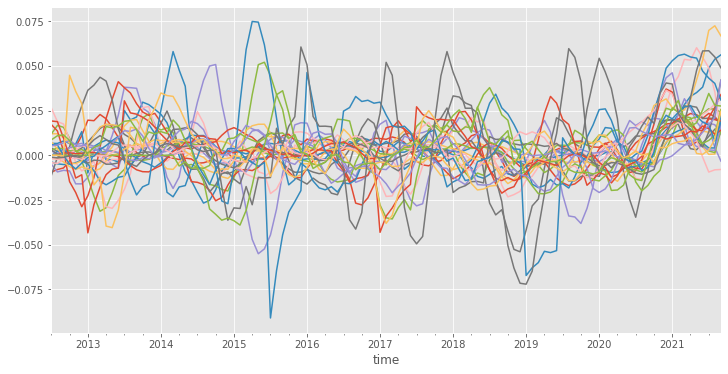

In [40]:
data_diff = data_minus_exp_roll_mean.diff(periods=6)

# Drop the missing values
data_diff.dropna(inplace=True)
data_diff.plot(figsize=(12,6), legend=False)

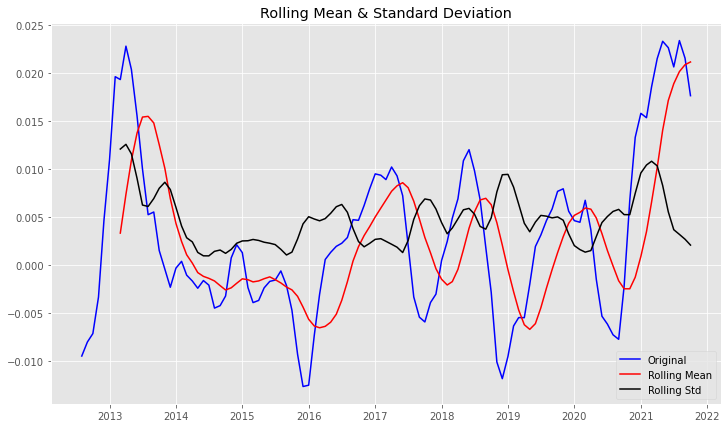

Test Statistic                  -3.574247
p-value                          0.006273
#Lags Used                       7.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


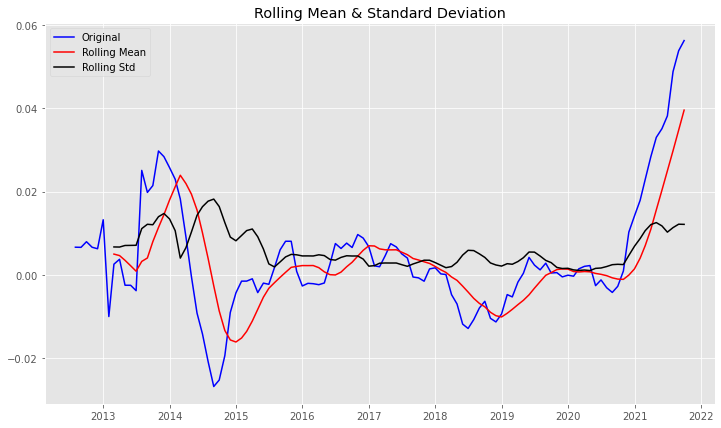

Test Statistic                  -1.777570
p-value                          0.391653
#Lags Used                       3.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


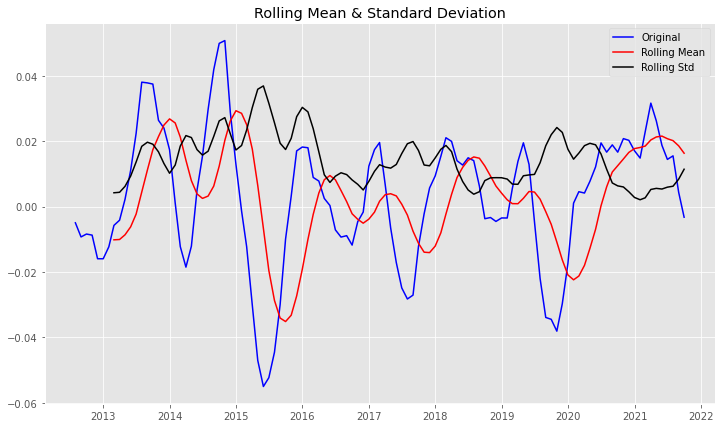

Test Statistic                 -4.024836
p-value                         0.001286
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


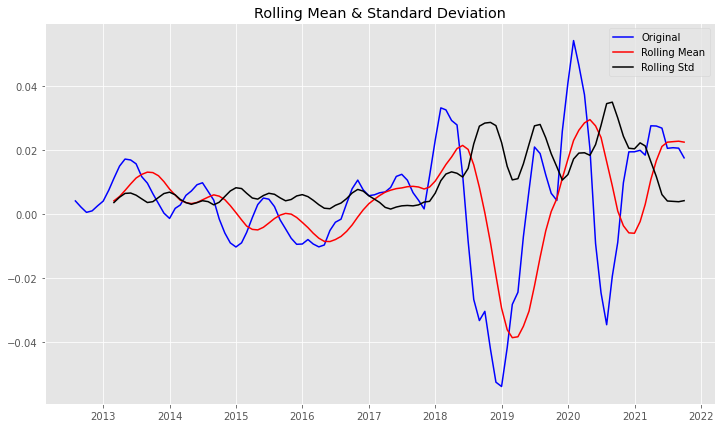

Test Statistic                 -3.217096
p-value                         0.019016
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


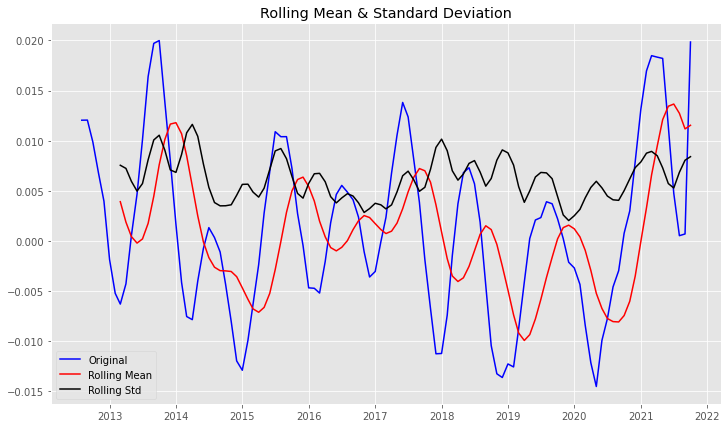

Test Statistic                  -0.162708
p-value                          0.942823
#Lags Used                       7.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


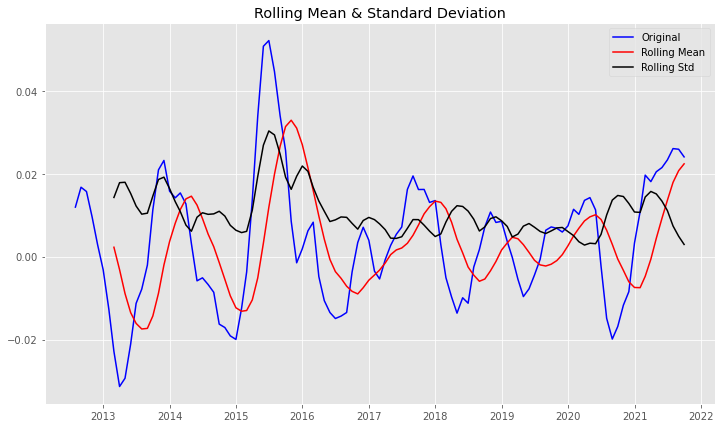

Test Statistic                 -3.796050
p-value                         0.002948
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


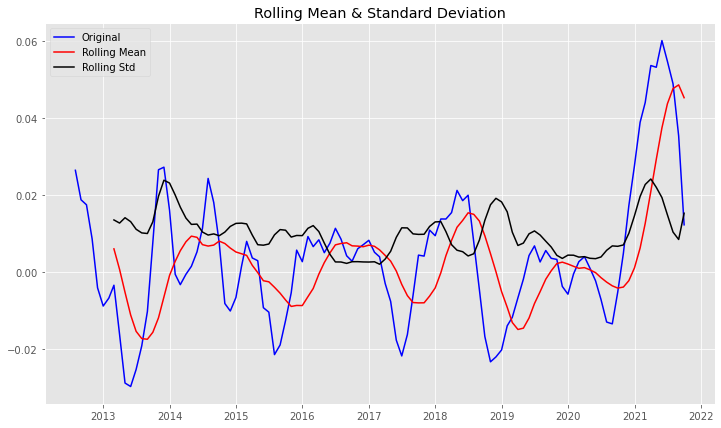

Test Statistic                 -2.631068
p-value                         0.086745
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


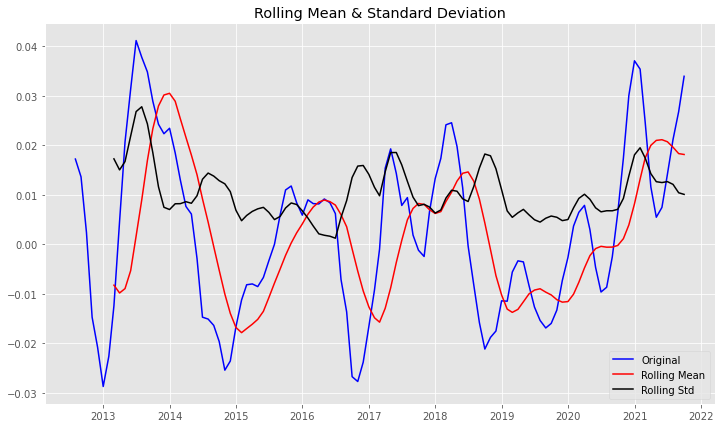

Test Statistic                 -4.083588
p-value                         0.001031
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


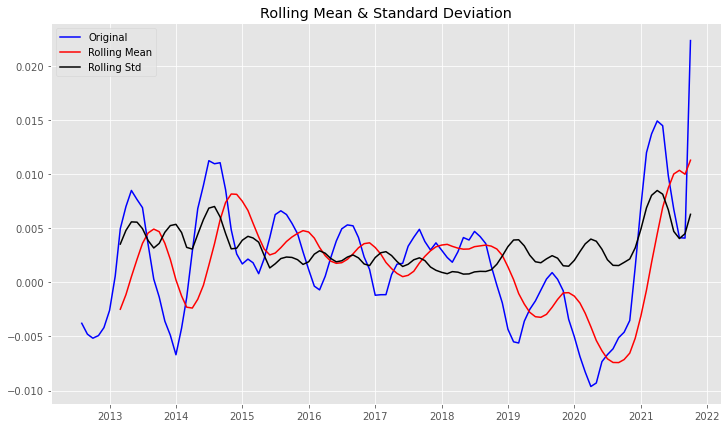

Test Statistic                 -0.131252
p-value                         0.946235
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


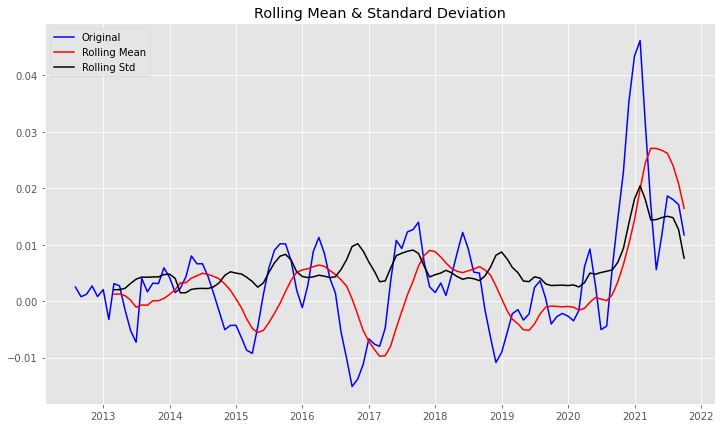

Test Statistic                 -2.763788
p-value                         0.063635
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


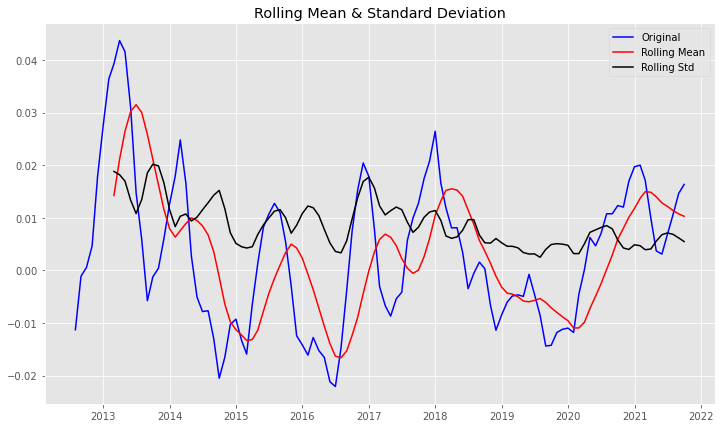

Test Statistic                 -2.335938
p-value                         0.160639
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


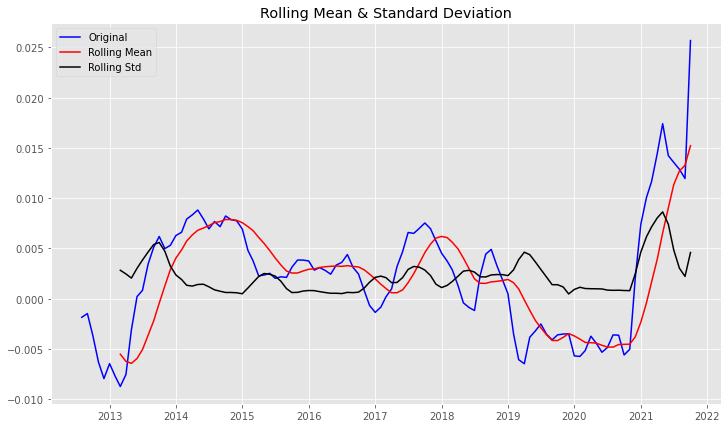

Test Statistic                 -1.240893
p-value                         0.655762
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


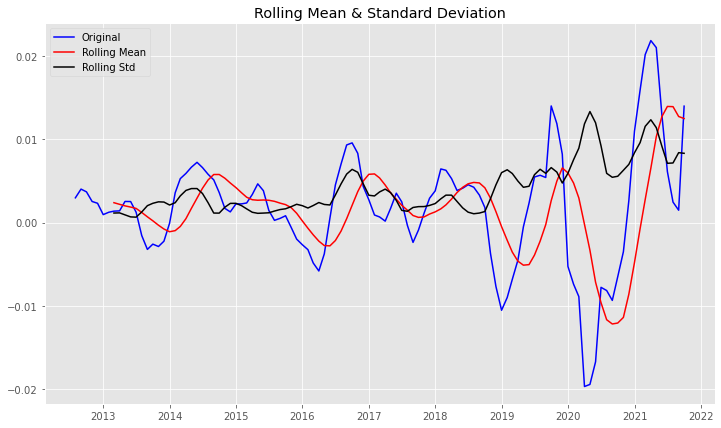

Test Statistic                  -3.251126
p-value                          0.017210
#Lags Used                       7.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


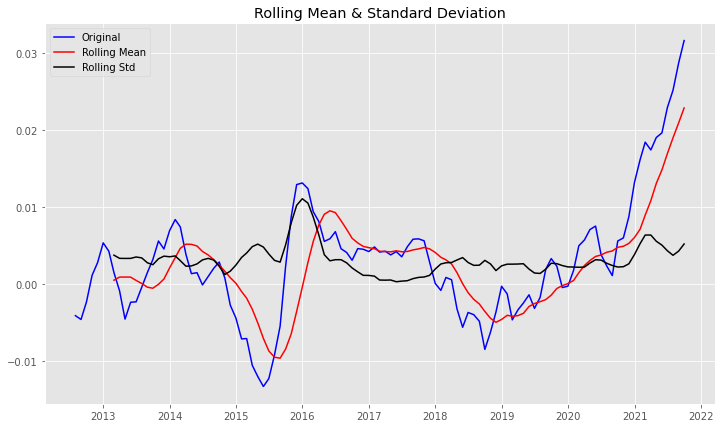

Test Statistic                  -0.924139
p-value                          0.779919
#Lags Used                       7.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


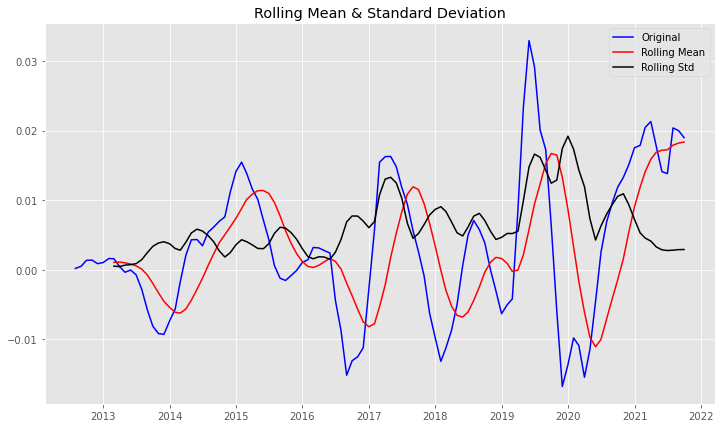

Test Statistic                 -3.866119
p-value                         0.002299
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


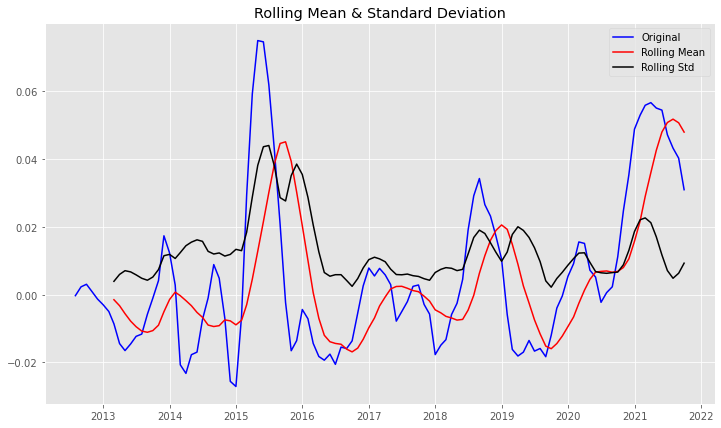

Test Statistic                 -2.007198
p-value                         0.283426
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


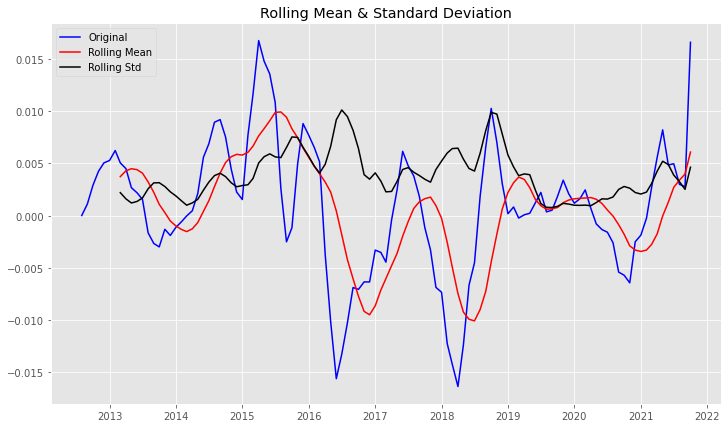

Test Statistic                  -2.780114
p-value                          0.061171
#Lags Used                       8.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


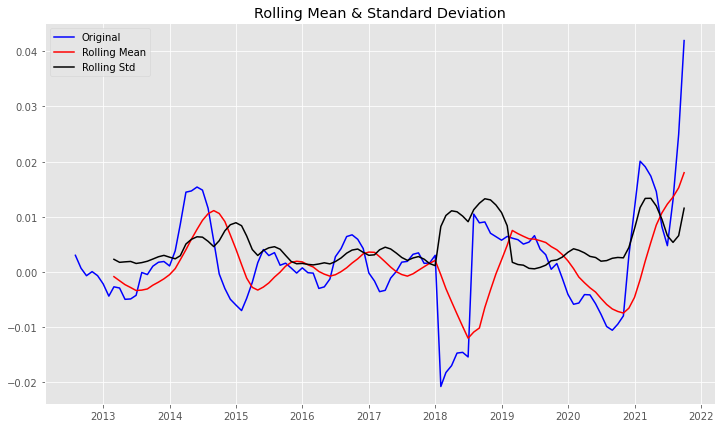

Test Statistic                 -1.693763
p-value                         0.434329
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


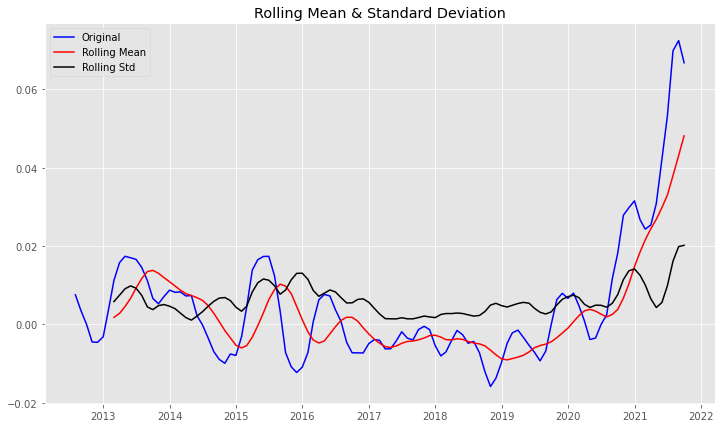

Test Statistic                 -0.701141
p-value                         0.846454
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


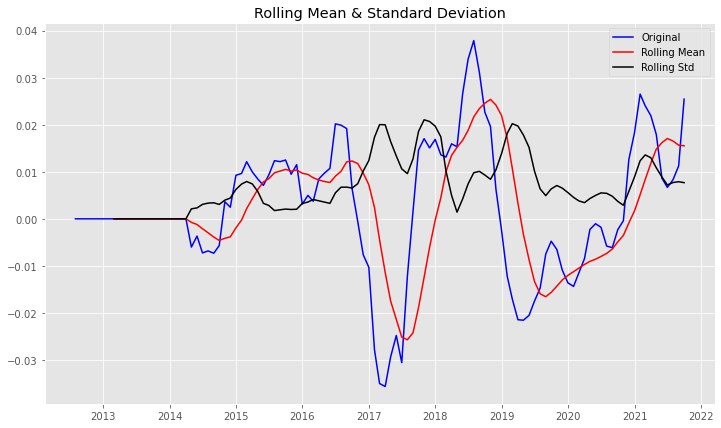

Test Statistic                 -3.279350
p-value                         0.015827
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


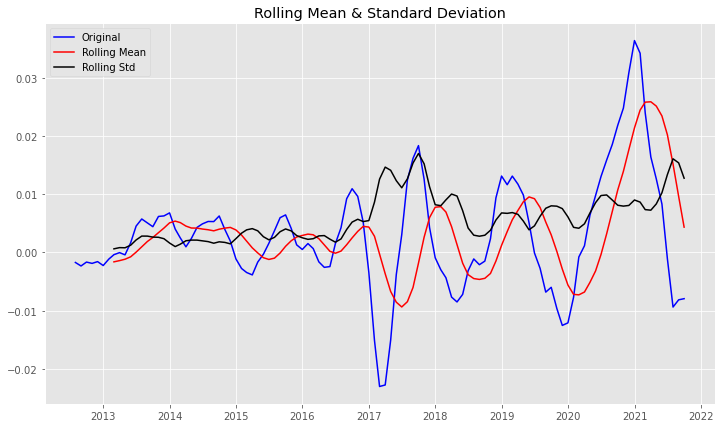

Test Statistic                 -3.078266
p-value                         0.028204
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


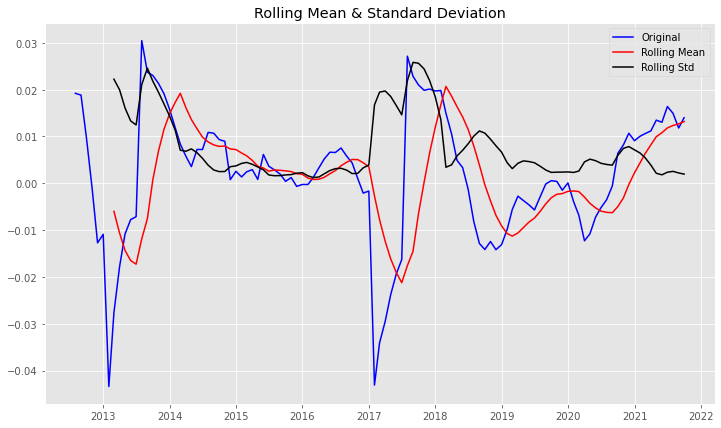

Test Statistic                  -3.914721
p-value                          0.001929
#Lags Used                       6.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


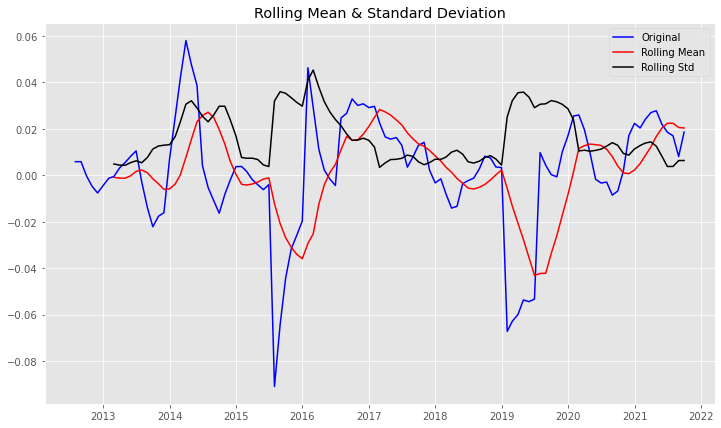

Test Statistic                  -2.590979
p-value                          0.094876
#Lags Used                       6.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


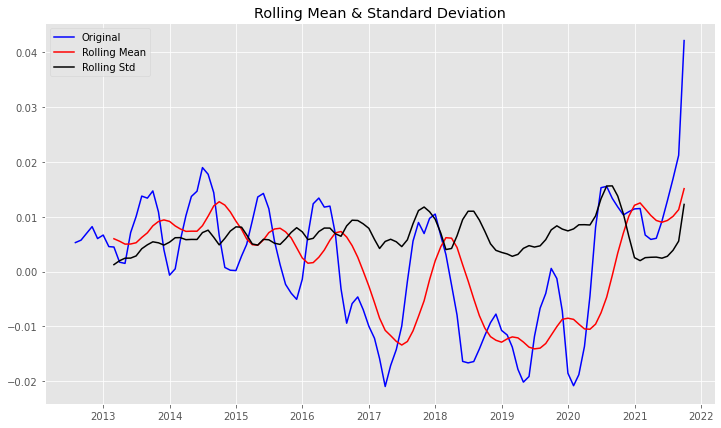

Test Statistic                  0.154050
p-value                         0.969563
#Lags Used                     11.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


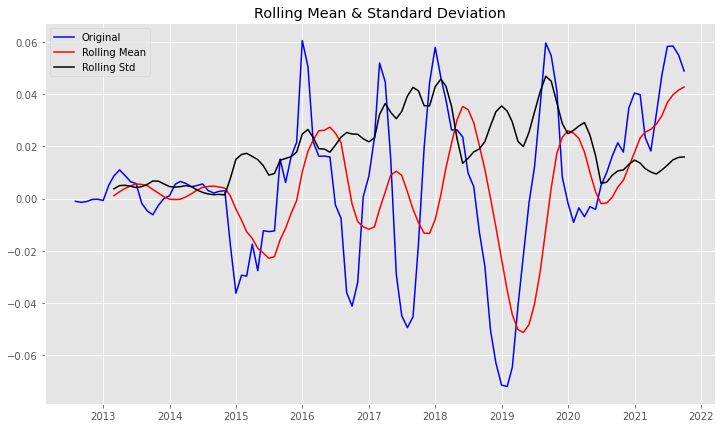

Test Statistic                 -2.245885
p-value                         0.190015
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


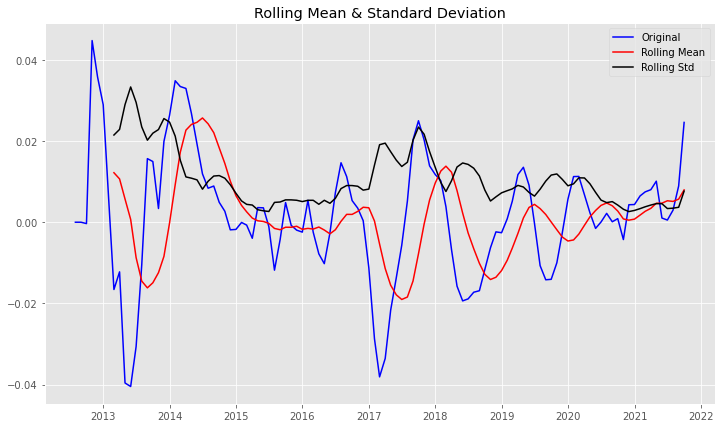

Test Statistic                 -2.008027
p-value                         0.283065
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


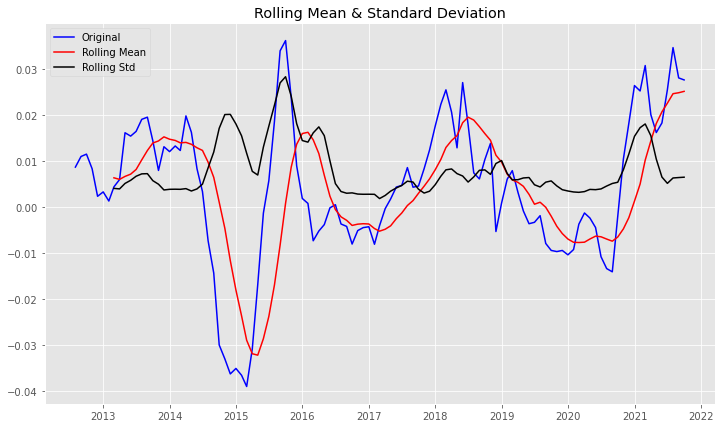

Test Statistic                 -2.932606
p-value                         0.041686
#Lags Used                     13.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


In [41]:
for column in data_diff.columns:
    output = stationarity_check(data_diff[column])
    print(output)

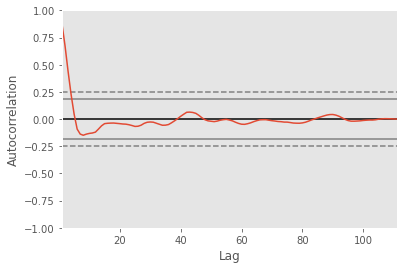

In [42]:
pd.plotting.autocorrelation_plot(data_diff);

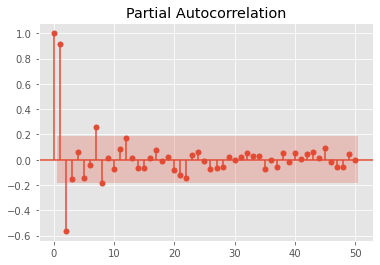

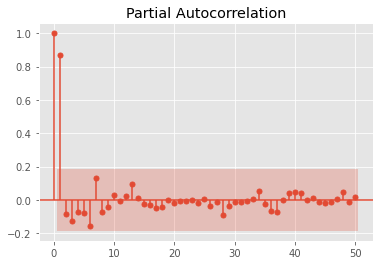

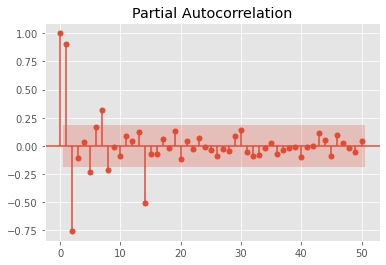

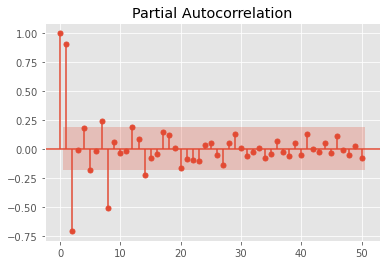

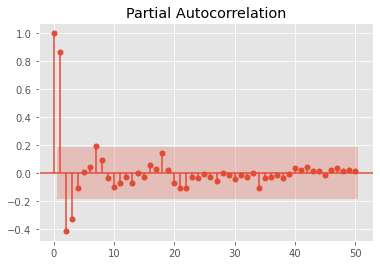

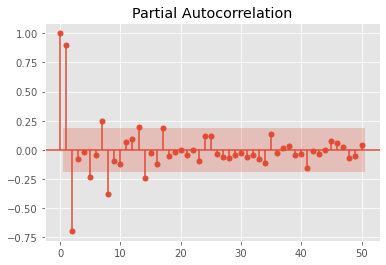

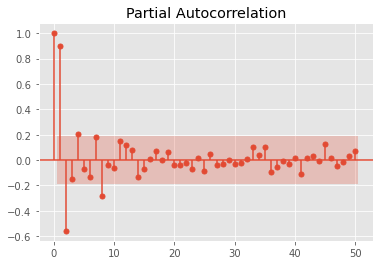

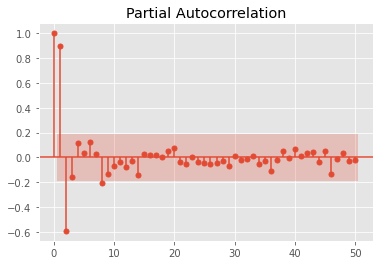

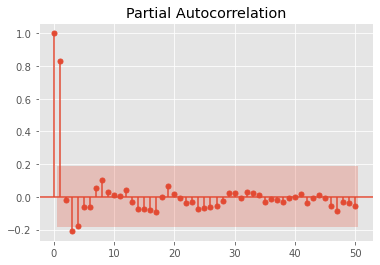

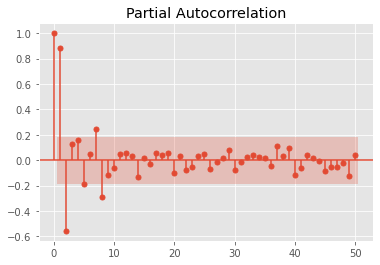

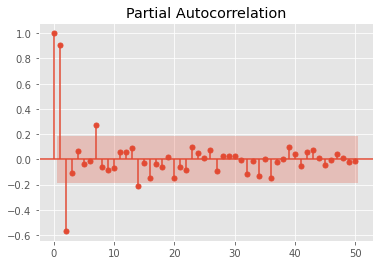

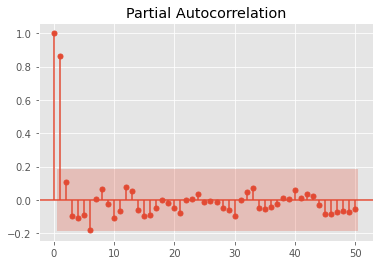

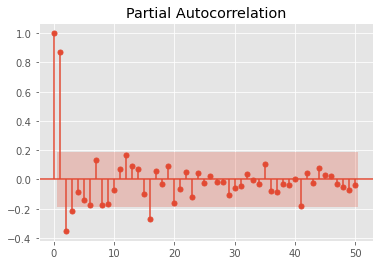

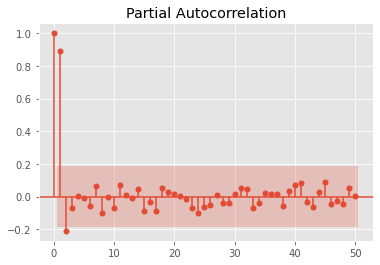

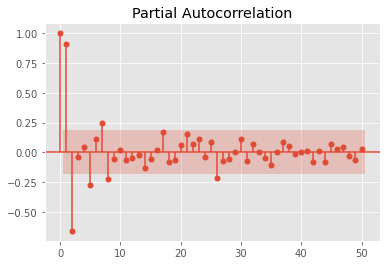

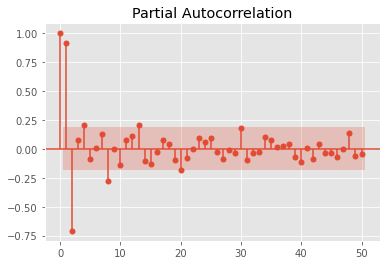

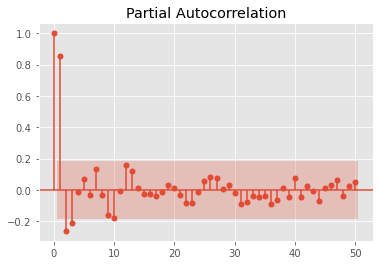

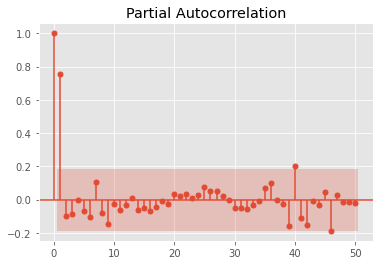

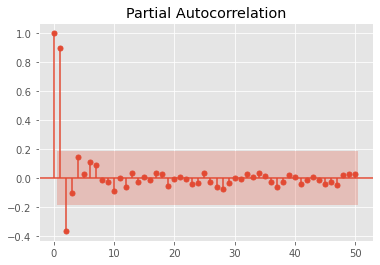

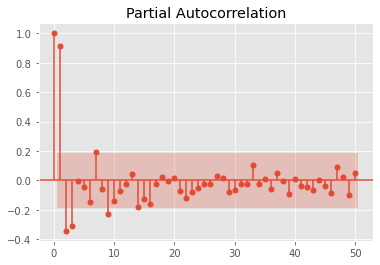

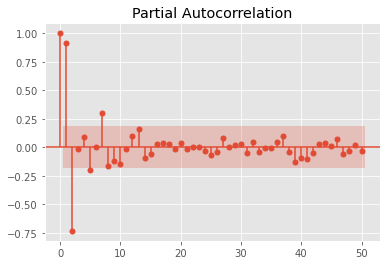

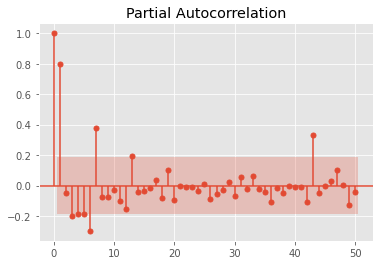

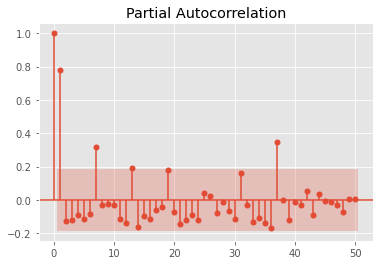

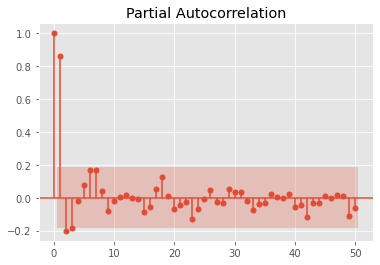

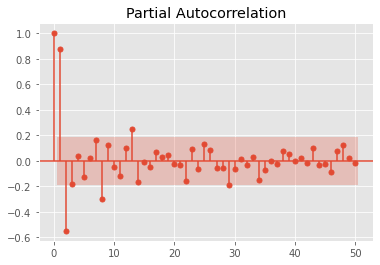

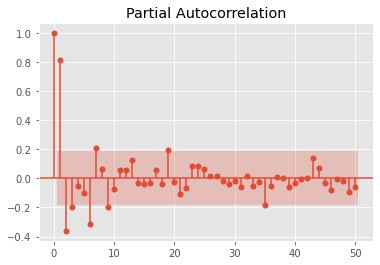

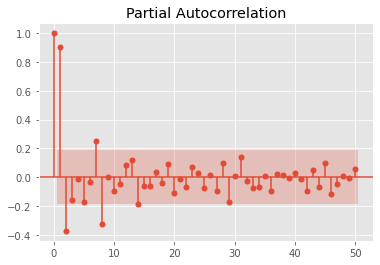

In [43]:
for column in data_diff.columns:
    plot_pacf(data_diff[column], lags=50, method='ywm');

In [44]:
for column in data_diff.columns:
    print(data_diff[column])

time
2012-07-31   -0.009439
2012-08-31   -0.007975
2012-09-30   -0.007099
2012-10-31   -0.003299
2012-11-30    0.004682
                ...   
2021-05-31    0.022681
2021-06-30    0.020677
2021-07-31    0.023421
2021-08-31    0.021587
2021-09-30    0.017681
Freq: M, Name: AL Shelby County value, Length: 111, dtype: float64
time
2012-07-31    0.006658
2012-08-31    0.006629
2012-09-30    0.007975
2012-10-31    0.006649
2012-11-30    0.006289
                ...   
2021-05-31    0.035079
2021-06-30    0.038151
2021-07-31    0.048751
2021-08-31    0.053766
2021-09-30    0.056207
Freq: M, Name: FL Volusia County value, Length: 111, dtype: float64
time
2012-07-31   -0.004978
2012-08-31   -0.009299
2012-09-30   -0.008413
2012-10-31   -0.008746
2012-11-30   -0.015971
                ...   
2021-05-31    0.018732
2021-06-30    0.014426
2021-07-31    0.015511
2021-08-31    0.004369
2021-09-30   -0.003264
Freq: M, Name: MI Monroe County value, Length: 111, dtype: float64
time
2012-07-31    0.004

# Modeling with SARIMAX


In [45]:
p = d = q = range(2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [46]:
pre_ans = []
i=0
for comb in pdq:
    for combs in pdqs:
            aics = []
            for column in final_ts.columns:
                try:
                    mod = sm.tsa.statespace.SARIMAX(final_ts[column],
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                
                    output = mod.fit()
                    aics.append(output.aic)
#                     print('{} is done for {}, {}'.format(column, comb, combs))
                except:
                    continue
            aics = np.array(aics)
            aics = aics[~np.isnan(aics)]
            mean = aics.mean()
            pre_ans.append([comb, combs, mean])
            print('ARIMA {} x {}12 : Mean AIC Calculated ={}'.format(comb, combs, mean))

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : Mean AIC Calculated =3209.315530652722
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : Mean AIC Calculated =518925.90722302353
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : Mean AIC Calculated =2296.776116961493
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : Mean AIC Calculated =2039.5870169345105
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : Mean AIC Calculated =2203.6390054989643
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : Mean AIC Calculated =2173.1676803083187
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : Mean AIC Calculated =1980.5772084982682
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : Mean AIC Calculated =2303.922594488691
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : Mean AIC Calculated =22563.85844541012
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : Mean AIC Calculated =492778.09624090866
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : Mean AIC Calculated =2249.044323870812
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : Mean AIC Calculated =2156.073907374978
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : Mean AIC Calculated =2905.5969510213827
ARIMA (0, 0, 1) x 

In [47]:
pre_ans_df = pd.DataFrame(pre_ans, columns=['pdq', 'pdqs', 'Mean AIC'])
pre_ans_df

pdq           pdqs       Mean AIC
0   (0, 0, 0)  (0, 0, 0, 12)    3209.315531
1   (0, 0, 0)  (0, 0, 1, 12)  518925.907223
2   (0, 0, 0)  (0, 1, 0, 12)    2296.776117
3   (0, 0, 0)  (0, 1, 1, 12)    2039.587017
4   (0, 0, 0)  (1, 0, 0, 12)    2203.639005
..        ...            ...            ...
59  (1, 1, 1)  (0, 1, 1, 12)    1553.849133
60  (1, 1, 1)  (1, 0, 0, 12)    1723.126095
61  (1, 1, 1)  (1, 0, 1, 12)    1707.954526
62  (1, 1, 1)  (1, 1, 0, 12)    1555.603845
63  (1, 1, 1)  (1, 1, 1, 12)    1537.670604

[64 rows x 3 columns]

In [ ]:
ans = []
i=0
for comb in pdq:
    for combs in pdqs:
            aics = []
            for column in data_diff.columns:
                try:
                    mod = sm.tsa.statespace.SARIMAX(data_diff[column],
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                
                    output = mod.fit()
                    aics.append(output.aic)
#                     print('{} is done for {}, {}'.format(column, comb, combs))
                except:
                    continue
            aics = np.array(aics)
            aics = aics[~np.isnan(aics)]
            mean = aics.mean()
            ans.append([comb, combs, mean])
            print('ARIMA {} x {}12 : Mean AIC Calculated ={}'.format(comb, combs, mean))

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : Mean AIC Calculated =-643.9380233249154
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : Mean AIC Calculated =-575.4821729930543
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : Mean AIC Calculated =-507.9840123699197
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : Mean AIC Calculated =-480.1726633653335
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : Mean AIC Calculated =-581.0141610521591
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : Mean AIC Calculated =-576.5428608737433
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : Mean AIC Calculated =-472.9460409045045
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : Mean AIC Calculated =-480.80297674030595
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : Mean AIC Calculated =-745.0092604012631
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : Mean AIC Calculated =-667.457393235057
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : Mean AIC Calculated =-600.9475096263341
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : Mean AIC Calculated =-558.6221510275471
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : Mean AIC Calculated =-681.5583240844642
ARIMA (0, 0,

In [ ]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'Mean AIC'])
ans_df.head()

In [ ]:
pre_ans_df.loc[pre_ans_df['Mean AIC'].idxmin()], ans_df.loc[ans_df['Mean AIC'].idxmax()]

In [ ]:
pre_ans_df

In [ ]:
print(1)